# Imports

In [1]:
# Remove duplicate imports and sort them alphabetically
import itertools
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns
import scipy.stats as stats
from scipy.stats import boxcox
import warnings

from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning

import xgboost as xgb

from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential

warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


# Import Dataset

The Dataset with the following columns is imported

used variables:
- Total vehicles sold (Target)
    - Company car tax rate (%)
    - Google  Home charging (G)
    - Consumer confidence (E)
    - Gasoline (Euro95) - Average price (F)





In [2]:
# Load data
df = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\Final.CSV")
df["Time Period (T)"] = pd.to_datetime(df["Time Period (T)"], format="%Y-%m-%d")
df = df.sort_values("Time Period (T)").reset_index(drop=True)
display(df.head())

Time Period (T)  Company car tax rate (%)  Home charging (G)  \
0      2007-01-01                        22                  0   
1      2007-02-01                        22                  0   
2      2007-03-01                        22                  0   
3      2007-04-01                        22                  0   
4      2007-05-01                        22                  0   

   Consumer confidence (E)  Gasoline (Euro95) - Average price (F)  \
0                     20.0                               1.303032   
1                     20.0                               1.325357   
2                     20.0                               1.379032   
3                     20.0                               1.426500   
4                     18.0                               1.466516   

   Total vehicles sold (Target)  
0                            31  
1                            39  
2                           123  
3                            62  
4                            84


> Following the steps for producing forcasts for time series data from Forecasting: Principles and Practice, the Pythonic Way, will be broken down into the following steps:

A structured process for producing forecasts:

0. Prepare the data (cleaning, formatting)
1. Visualize to identify patterns

    1a. split and transform the data split again
	Then just plot differencing, and say auto arima would probably use first differencing
2. Use automated algorithm 
Specify a model (using autoarima)
3. Check residuals  by plotting ACF of the residential and doing Portmanteau test > Ljung–Box Test: A refined version introduced in 1978 that adjusts for sample size and is more accurate
4. Do residuals look like white noise? If no plot ACF and check other candidate models.
Otherwise 
5. Generate forecasts
6. continue with specified  model and  add lagged features
	For lagged features check BIC+


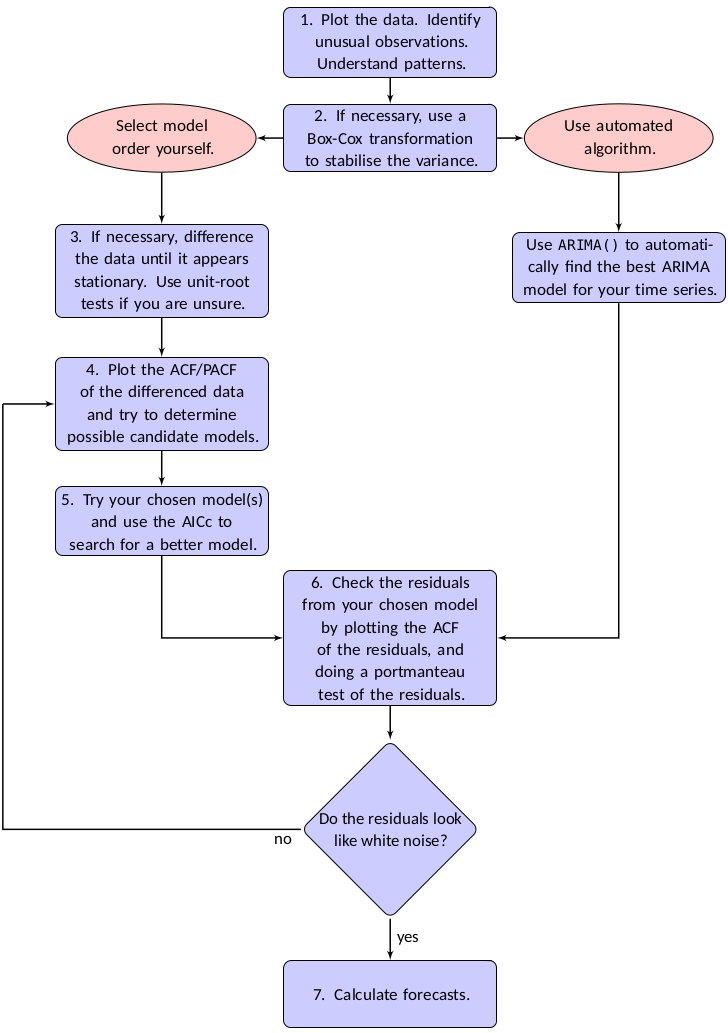



# 1. Prepare the data (cleaning, formatting) this was done in 
C:\Users\dylan\Trying hard\Tryhard\100%\Preprocessing.ipynb 

# 2. Visualize to identify patterns

to visualize and identify patterns in the data, we will use:
1. time series plots: here we can see 
these plots enable many features of the data to be visualised, including patterns, unusual observations, changes over time, and relationships between variables.
2. Scatterplot matrix:
    is used to explore relationships between time series.
3. Correlation matrix:
    is used to explore relationships between time series.

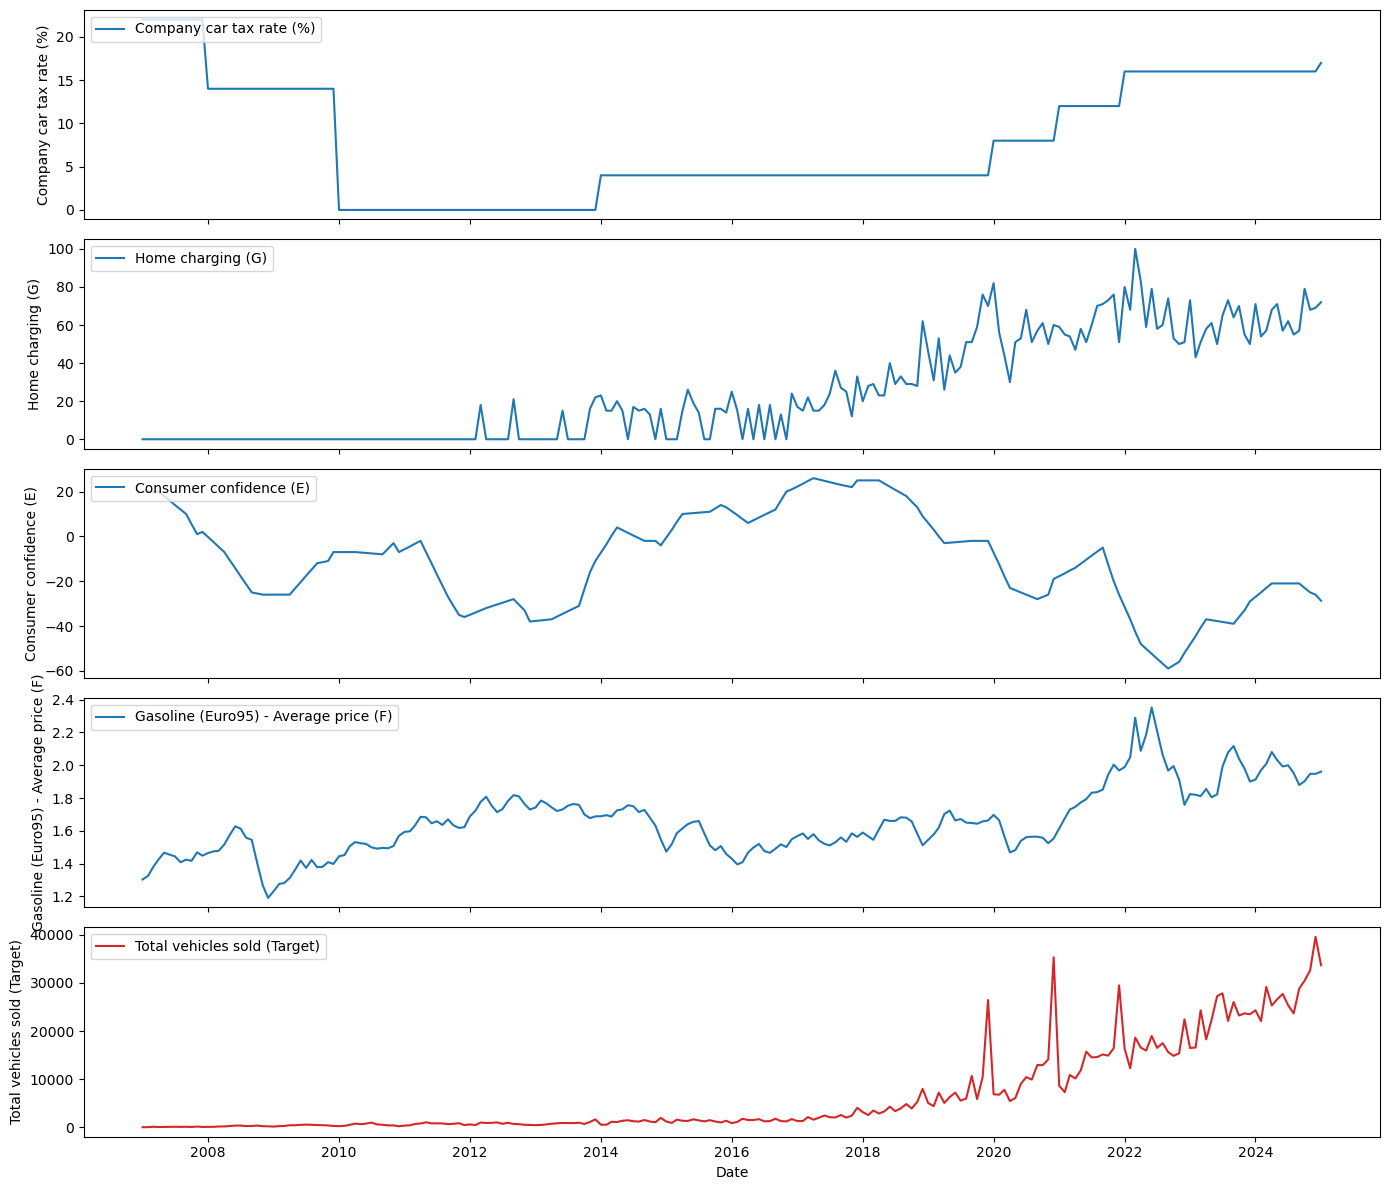

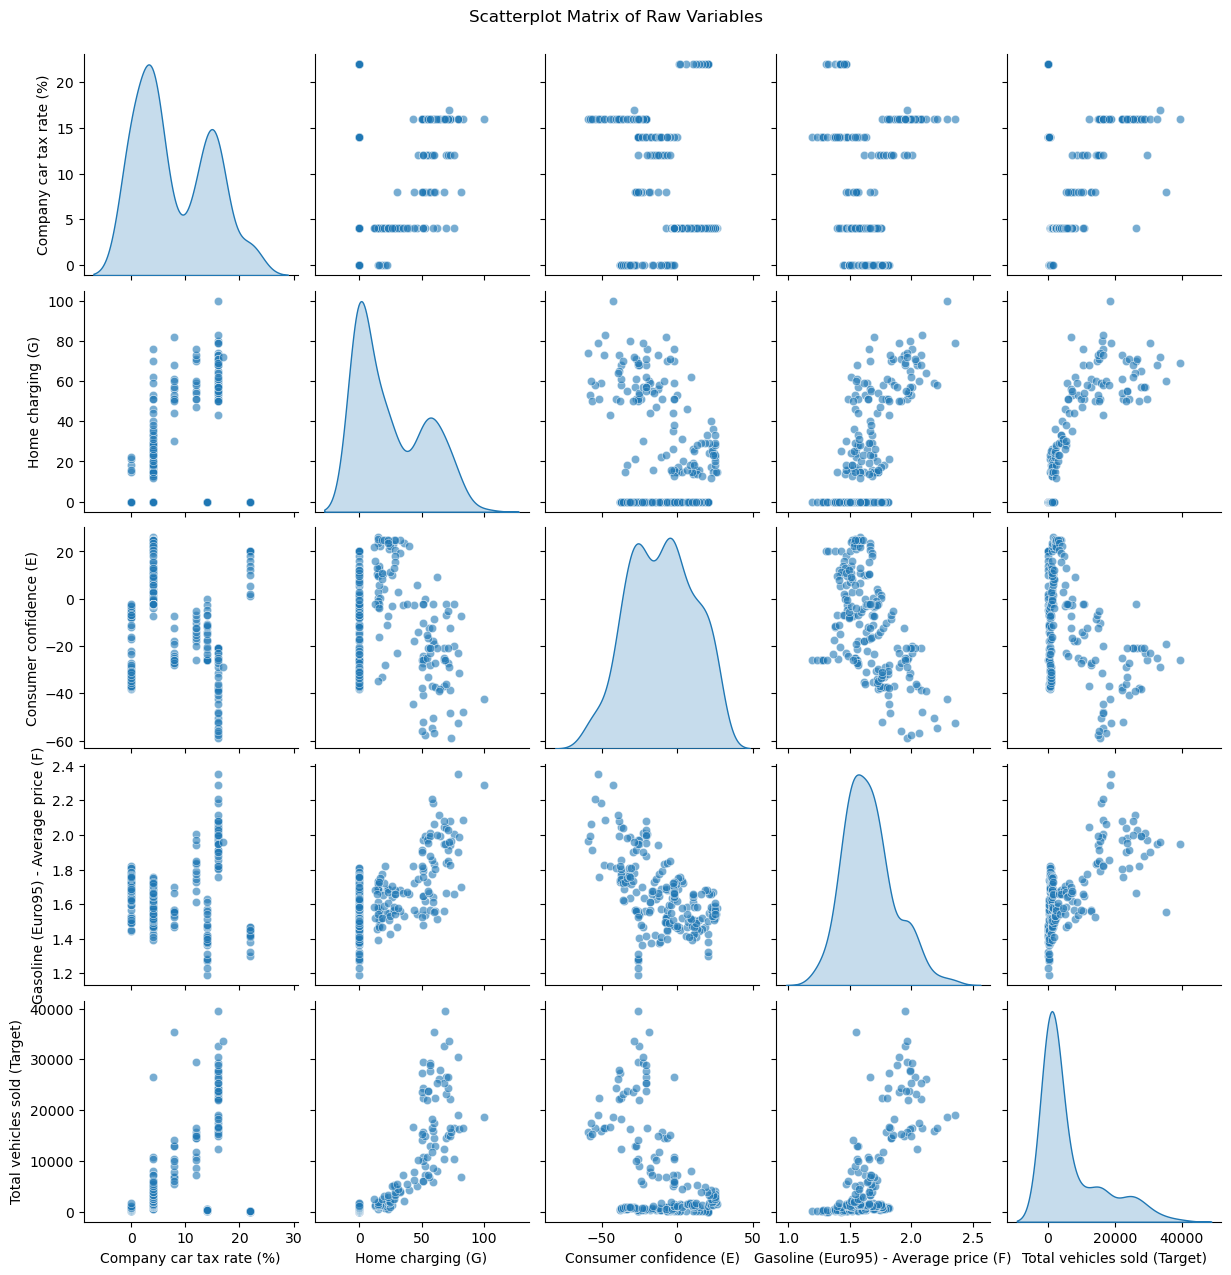

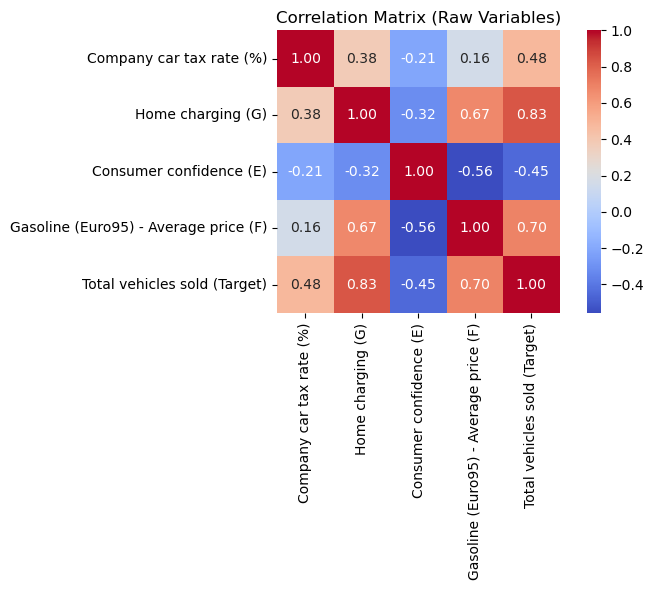

In [3]:
# Define features and target
features = ['Company car tax rate (%)', 'Home charging (G)', 'Consumer confidence (E)', 'Gasoline (Euro95) - Average price (F)']
target = 'Total vehicles sold (Target)'

fig, axs = plt.subplots(len(features) + 1, 1, figsize=(14, 12), sharex=True)

for i, col in enumerate(features):
    axs[i].plot(df["Time Period (T)"], df[col], label=col)
    axs[i].set_ylabel(col)
    axs[i].legend(loc="upper left")

axs[-1].plot(df["Time Period (T)"], df[target], label=target, color='tab:red')
axs[-1].set_ylabel(target)
axs[-1].set_xlabel("Date")
axs[-1].legend(loc="upper left")

plt.tight_layout()
plt.show()

# Scatterplot matrix (pairplot) for all features and target
sns.pairplot(df[features + [target]], diag_kind="kde", plot_kws={'alpha':0.6})
plt.suptitle("Scatterplot Matrix of Raw Variables", y=1.02)
plt.show()

# Correlation matrix for all features and target
corr_matrix = df[features + [target]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (Raw Variables)")
plt.tight_layout()
plt.show()


## Observations first plots 

> Talk about Trends: upward or downward drift over years.

Seasonality: recurring cycles (e.g., year-end sales spike).

Structural breaks: sudden shifts or regime changes.

Outliers: one-off jumps or drops.

key observations from the scattorplot matrix:

- Home charging and gasoline price show a moderately positive association with total vehicles sold, as indicated by the upward trend in their scatterplots.

- Company car tax rate appears to have a non-linear relationship with total vehicles sold; vehicle sales tend to increase when tax rates are lower.

- Consumer confidence shows a weaker, noisier relationship with vehicle sales, though a vague upward trend is present.

- Home charging shows strong positive correlation with gasoline prices, potentially reflecting a structural shift in energy preference.

# 3. Model Specification (NOG Afmaken)



My baseline approach will be: .... and  will integrate exogenous drivers:
using Arima, 

# 4. Data Split & Transformations

## 4a Apply train/val/test split

In [4]:
# Define features and target (raw data)
features_raw = ['Company car tax rate (%)', 'Home charging (G)', 'Consumer confidence (E)', 'Gasoline (Euro95) - Average price (F)']
target_raw = 'Total vehicles sold (Target)'

# Calculate split indices
n = len(df)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

# Split the target (raw)
y_raw = df[target_raw]
y_train_raw = y_raw.iloc[:train_end]
y_val_raw = y_raw.iloc[train_end:val_end]
y_test_raw = y_raw.iloc[val_end:]

# Split each feature separately (raw)
companytax_train_raw = df['Company car tax rate (%)'].iloc[:train_end]
companytax_val_raw = df['Company car tax rate (%)'].iloc[train_end:val_end]
companytax_test_raw = df['Company car tax rate (%)'].iloc[val_end:]

homechg_train_raw = df['Home charging (G)'].iloc[:train_end]
homechg_val_raw = df['Home charging (G)'].iloc[train_end:val_end]
homechg_test_raw = df['Home charging (G)'].iloc[val_end:]

conf_train_raw = df['Consumer confidence (E)'].iloc[:train_end]
conf_val_raw = df['Consumer confidence (E)'].iloc[train_end:val_end]
conf_test_raw = df['Consumer confidence (E)'].iloc[val_end:]

gas_train_raw = df['Gasoline (Euro95) - Average price (F)'].iloc[:train_end]
gas_val_raw = df['Gasoline (Euro95) - Average price (F)'].iloc[train_end:val_end]
gas_test_raw = df['Gasoline (Euro95) - Average price (F)'].iloc[val_end:]


# Print sizes
print(f"Train: {df['Time Period (T)'].iloc[y_train_raw.index[0]]} to {df['Time Period (T)'].iloc[y_train_raw.index[-1]]} | {len(y_train_raw)/n:.1%} of data")
print(f"Val:   {df['Time Period (T)'].iloc[y_val_raw.index[0]]} to {df['Time Period (T)'].iloc[y_val_raw.index[-1]]} | {len(y_val_raw)/n:.1%} of data")
print(f"Test:  {df['Time Period (T)'].iloc[y_test_raw.index[0]]} to {df['Time Period (T)'].iloc[y_test_raw.index[-1]]} | {len(y_test_raw)/n:.1%} of data")
print(f"Train size: {len(y_train_raw)}, Val size: {len(y_val_raw)}, Test size: {len(y_test_raw)}")




Train: 2007-01-01 00:00:00 to 2021-05-01 00:00:00 | 79.7% of data
Val:   2021-06-01 00:00:00 to 2023-03-01 00:00:00 | 10.1% of data
Test:  2023-04-01 00:00:00 to 2025-01-01 00:00:00 | 10.1% of data
Train size: 173, Val size: 22, Test size: 22


#### Deze plot zou ook weggelaten kunnen worden 

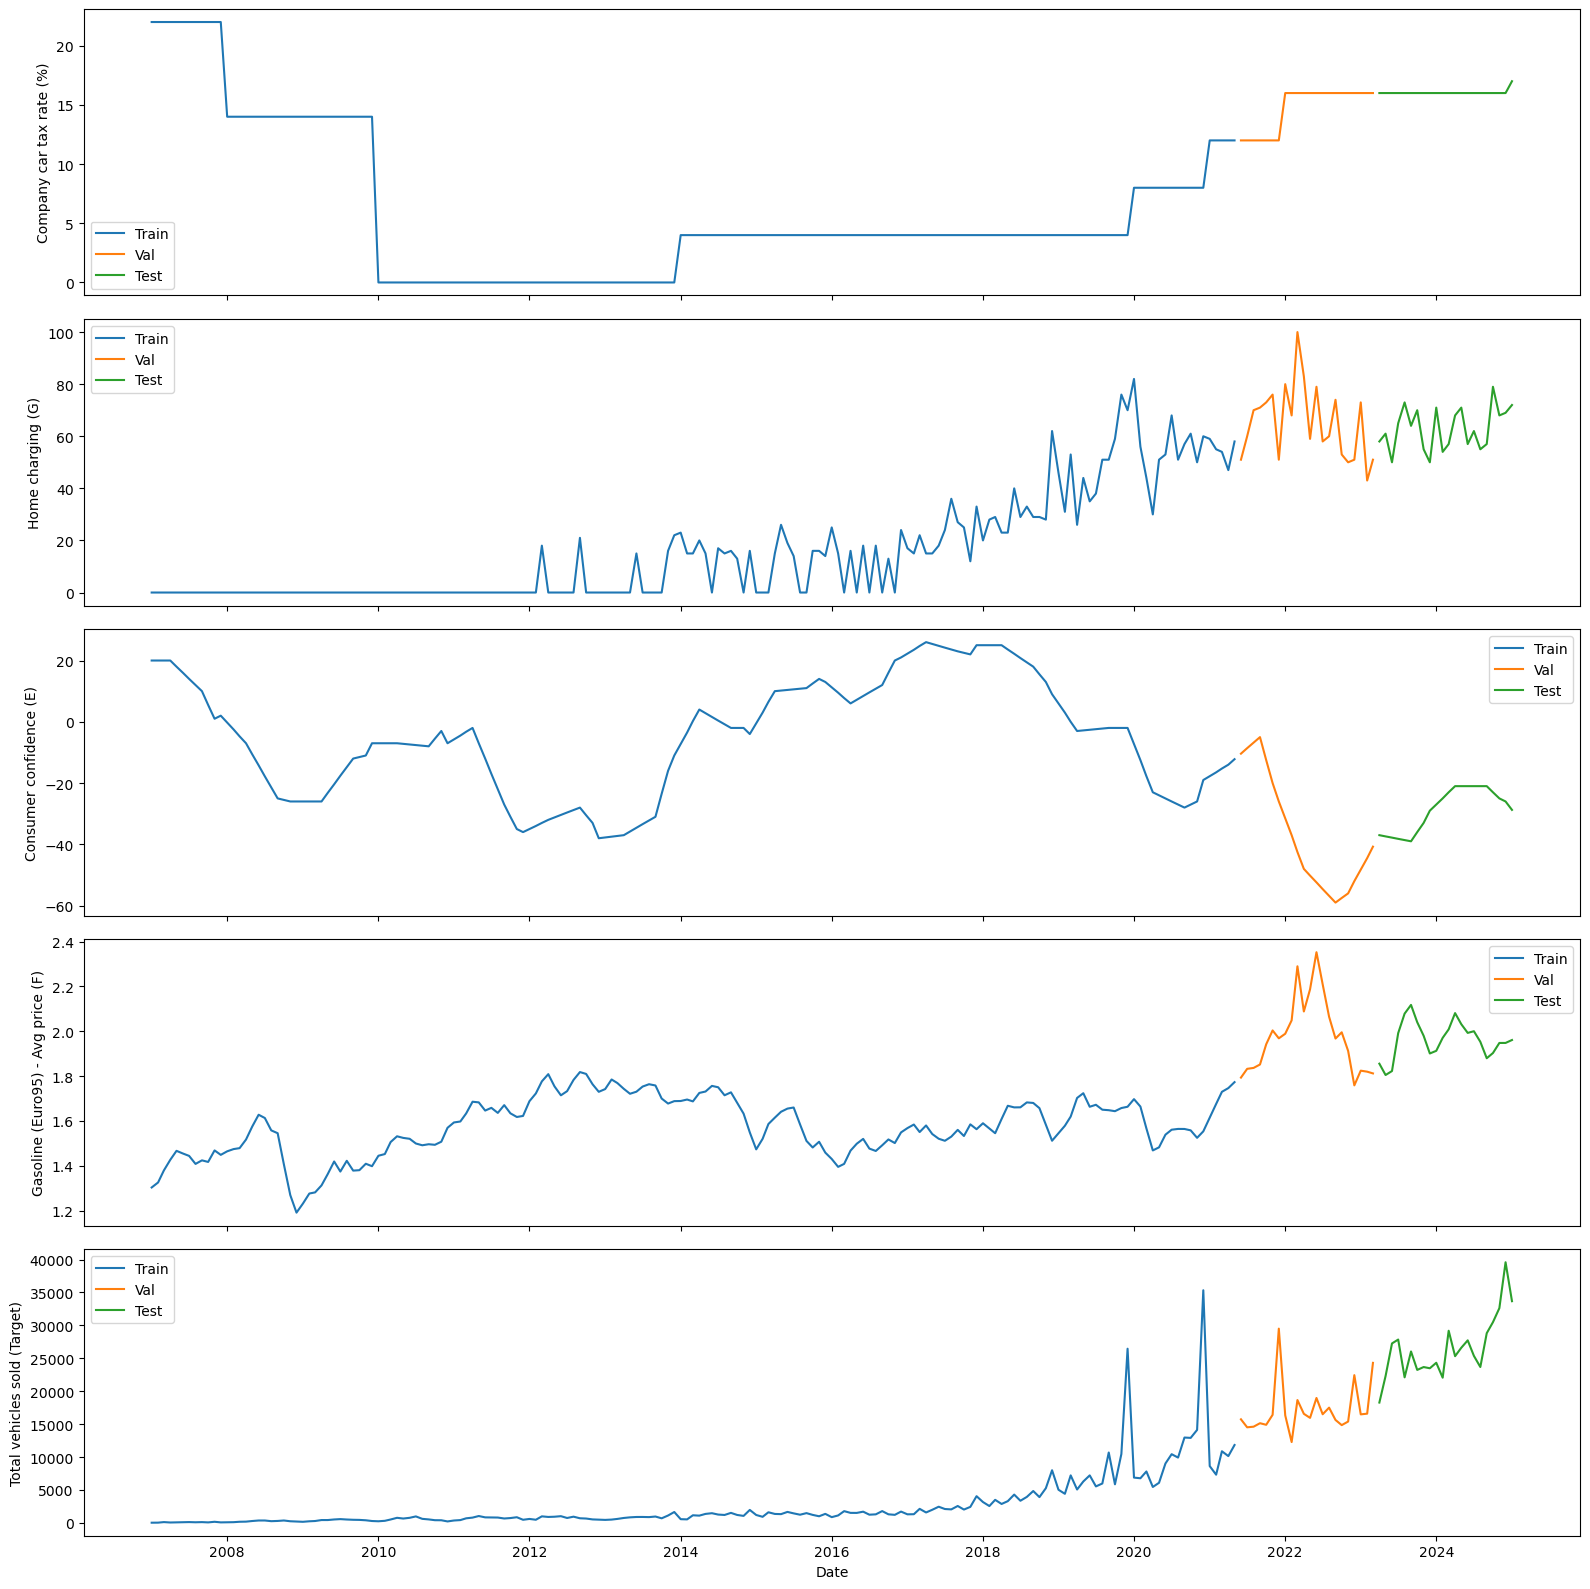

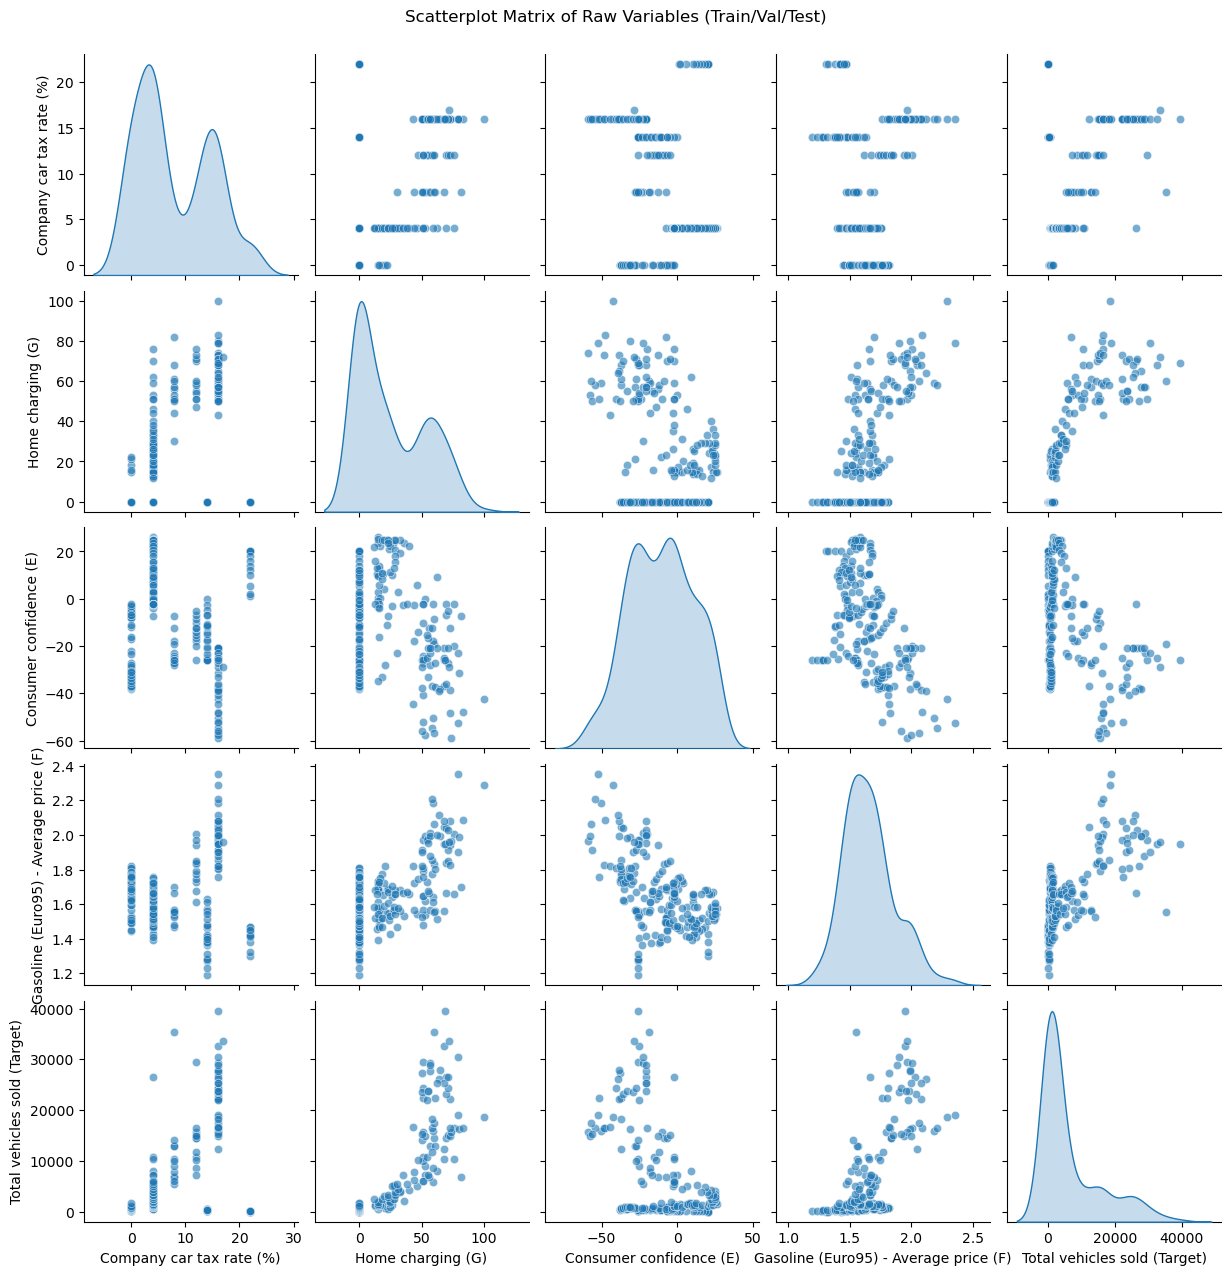

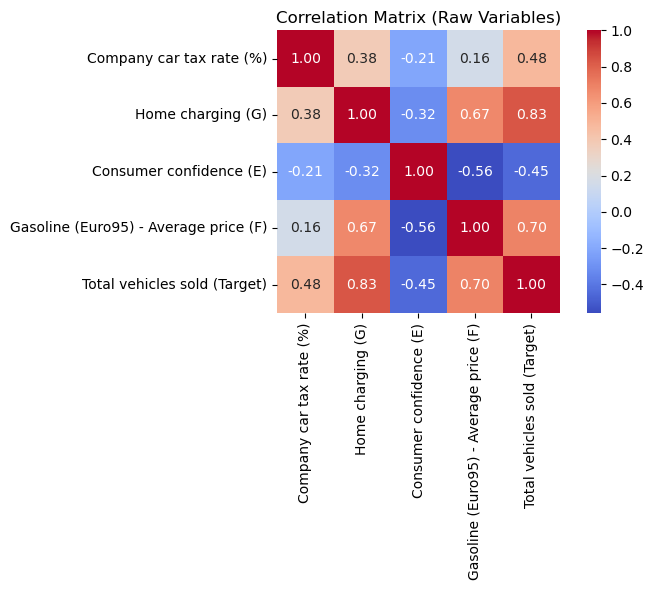

=== Unit Root Tests (ADF/KPSS) on Raw Train Splits ===
Company car tax rate (%)
  ADF: stat=-2.418, p=0.137 | Non-stationary
  KPSS: stat=0.584, p=0.0241 | Non-stationary

Home charging (G)
  ADF: stat=0.083, p=0.965 | Non-stationary
  KPSS: stat=1.618, p=0.01 | Non-stationary

Consumer confidence (E)
  ADF: stat=-2.337, p=0.16 | Non-stationary
  KPSS: stat=0.328, p=0.1 | Stationary

Gasoline (Euro95) - Average price (F)
  ADF: stat=-3.250, p=0.0173 | Stationary
  KPSS: stat=0.507, p=0.04 | Non-stationary

Total vehicles sold (Target)
  ADF: stat=6.289, p=1 | Non-stationary
  KPSS: stat=1.296, p=0.01 | Non-stationary



C:\Users\dylan\AppData\Local\Temp\ipykernel_24228\1550215762.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags="auto")
C:\Users\dylan\AppData\Local\Temp\ipykernel_24228\1550215762.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags="auto")
C:\Users\dylan\AppData\Local\Temp\ipykernel_24228\1550215762.py:65: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags="auto")


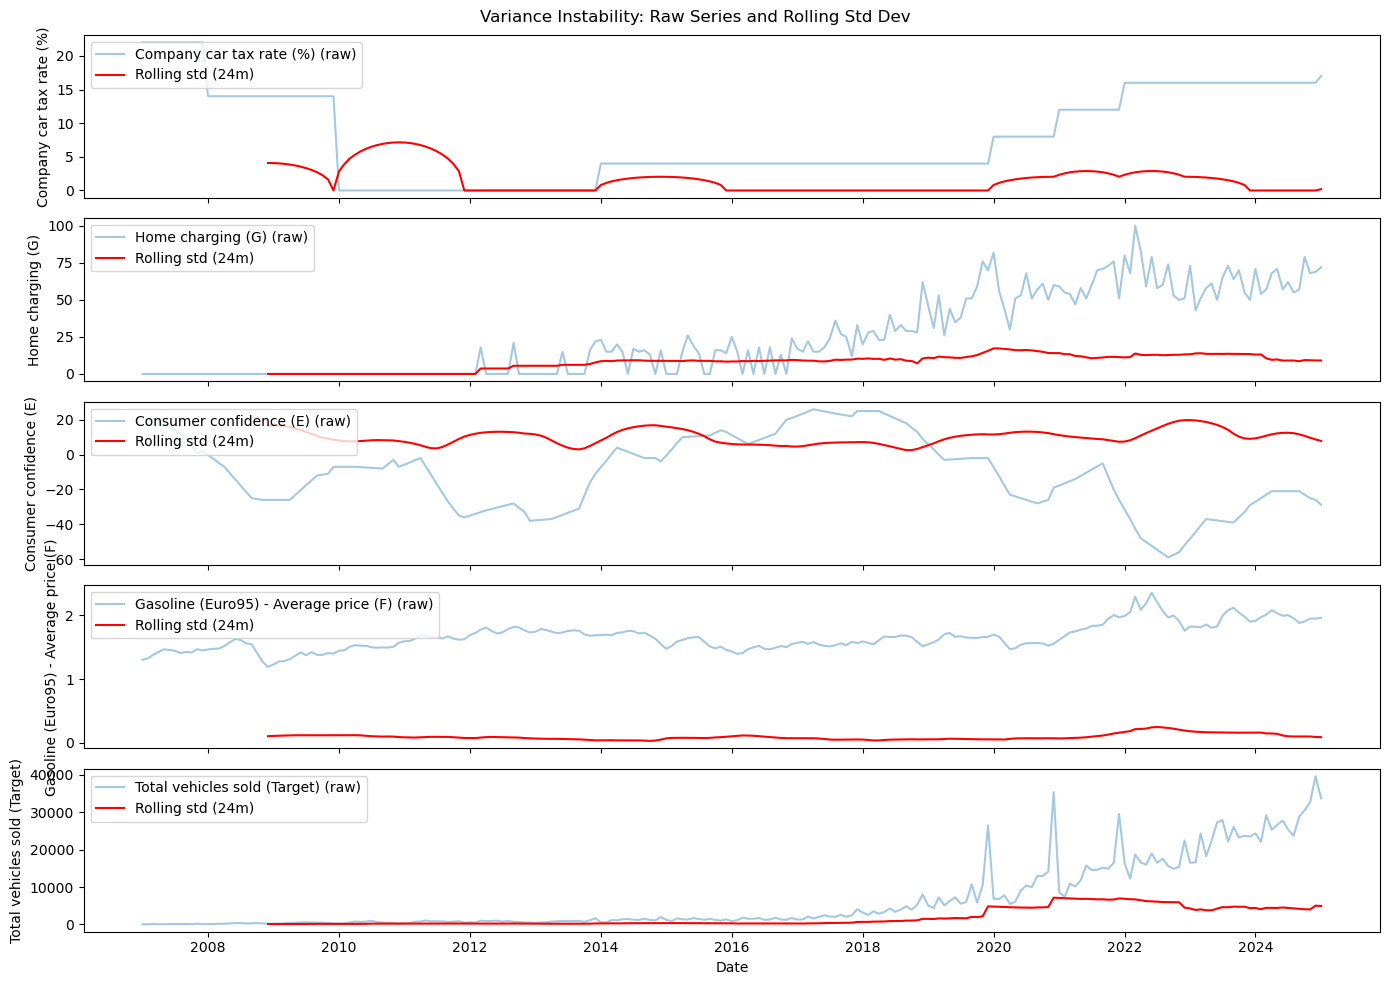

In [5]:
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss


fig, axs = plt.subplots(5, 1, figsize=(16, 16), sharex=True)

# 1. Company car tax rate (%)
axs[0].plot(df['Time Period (T)'].iloc[:train_end], companytax_train_raw, label='Train')
axs[0].plot(df['Time Period (T)'].iloc[train_end:val_end], companytax_val_raw, label='Val')
axs[0].plot(df['Time Period (T)'].iloc[val_end:], companytax_test_raw, label='Test')
axs[0].set_ylabel('Company car tax rate (%)')
axs[0].legend()

# 2. Home charging (G)
axs[1].plot(df['Time Period (T)'].iloc[:train_end], homechg_train_raw, label='Train')
axs[1].plot(df['Time Period (T)'].iloc[train_end:val_end], homechg_val_raw, label='Val')
axs[1].plot(df['Time Period (T)'].iloc[val_end:], homechg_test_raw, label='Test')
axs[1].set_ylabel('Home charging (G)')
axs[1].legend()

# 3. Consumer confidence (E)
axs[2].plot(df['Time Period (T)'].iloc[:train_end], conf_train_raw, label='Train')
axs[2].plot(df['Time Period (T)'].iloc[train_end:val_end], conf_val_raw, label='Val')
axs[2].plot(df['Time Period (T)'].iloc[val_end:], conf_test_raw, label='Test')
axs[2].set_ylabel('Consumer confidence (E)')
axs[2].legend()

# 4. Gasoline (Euro95) - Average price (F)
axs[3].plot(df['Time Period (T)'].iloc[:train_end], gas_train_raw, label='Train')
axs[3].plot(df['Time Period (T)'].iloc[train_end:val_end], gas_val_raw, label='Val')
axs[3].plot(df['Time Period (T)'].iloc[val_end:], gas_test_raw, label='Test')
axs[3].set_ylabel('Gasoline (Euro95) - Avg price (F)')
axs[3].legend()

# 5. Total vehicles sold (Target)
axs[4].plot(df['Time Period (T)'].iloc[:train_end], y_train_raw, label='Train')
axs[4].plot(df['Time Period (T)'].iloc[train_end:val_end], y_val_raw, label='Val')
axs[4].plot(df['Time Period (T)'].iloc[val_end:], y_test_raw, label='Test')
axs[4].set_ylabel('Total vehicles sold (Target)')
axs[4].set_xlabel('Date')
axs[4].legend()

plt.tight_layout()
plt.show()

# Scatter plot matrix (pairplot) for all features and target (raw splits)

sns.pairplot(df[features_raw + [target_raw]], diag_kind="kde", plot_kws={'alpha':0.6})
plt.suptitle("Scatterplot Matrix of Raw Variables (Train/Val/Test)", y=1.02)
plt.show()

# Correlation matrix for all features and target (raw splits)
corr_matrix = df[features_raw + [target_raw]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (Raw Variables)")
plt.tight_layout()
plt.show()

# --- Unit root (ADF/KPSS) and variance instability plots for raw splits ---


def adf_kpss_summary(series, name):
    adf_stat, adf_p, _, _, adf_crit, _ = adfuller(series, autolag='AIC', maxlag=12, regression='c', store=False)
    kpss_stat, kpss_p, _, kpss_crit = kpss(series, regression='c', nlags="auto")
    print(f"\033[1m{name}\033[0m")
    print(f"  ADF: stat={adf_stat:.3f}, p={adf_p:.3g} | {'Stationary' if adf_p < 0.05 else 'Non-stationary'}")
    print(f"  KPSS: stat={kpss_stat:.3f}, p={kpss_p:.3g} | {'Non-stationary' if kpss_p < 0.05 else 'Stationary'}")
    print()

print("=== Unit Root Tests (ADF/KPSS) on Raw Train Splits ===")
for col, train_split in zip(features_raw + [target_raw],
                            [companytax_train_raw, homechg_train_raw, conf_train_raw, gas_train_raw, y_train_raw]):
    adf_kpss_summary(train_split, col)

# --- Variance instability: rolling std plot for each variable (raw) ---
window = 24 # 2 years for monthly data

fig, axs = plt.subplots(len(features_raw) + 1, 1, figsize=(14, 10), sharex=True)
for i, col in enumerate(features_raw + [target_raw]):
    rolling_std = df[col].rolling(window=window).std() # kan aangepast woorden naar varience var 
    axs[i].plot(df["Time Period (T)"], df[col], alpha=0.4, label=f"{col} (raw)")
    axs[i].plot(df["Time Period (T)"], rolling_std, color='red', label=f"Rolling std ({window}m)")
    axs[i].set_ylabel(col)
    axs[i].legend(loc="upper left")
axs[-1].set_xlabel("Date")
plt.suptitle("Variance Instability: Raw Series and Rolling Std Dev")
plt.tight_layout()
plt.show()


> Since there is alot of varience i will add boxcox transformation to the data, this will help to stabilize the variance and make the data more suitable for modeling.

## 4b Yeo–Johnson transformation 

Yeo–Johnson (like Box–Cox) primarily targets skewness—it finds a power transform that makes the distribution more symmetric and stabilizes variance globally. But time‐series variance often shifts because of:

Trends or level changes

Seasonal effects (e.g. summer peaks vs. winter troughs)

Structural breaks or exogenous shocks

In [6]:
# 1. Fit Yeo–Johnson on train and transform all
from sklearn.preprocessing import PowerTransformer  # Import PowerTransformer for Yeo–Johnson transformation

features_yj = features_raw.copy()  # Copy the list of raw feature names for transformation
target_yj   = target_raw           # Set the target variable name for transformation

yeojohnson_all      = {}           # Dictionary to store transformed values for each column
yeojohnson_lambdas_all = {}        # Dictionary to store the lambda parameter for each column

for col in features_yj + [target_yj]:  # Loop through all features and the target
    train_series = df[col].iloc[:train_end].values.reshape(-1, 1)  # Get training data for the column and reshape for transformer
    pt = PowerTransformer(method='yeo-johnson', standardize=False) # Create transformer (no standardization)
    pt.fit(train_series)                                           # Fit transformer on training data only
    yeojohnson_lambdas_all[col] = pt.lambdas_[0]                   # Store the learned lambda for this column

    full_series = df[col].values.reshape(-1, 1)                    # Get the full column data for transformation
    yeojohnson_all[col] = pt.transform(full_series).flatten()      # Transform the full data and flatten to 1D

# 2. Build transformed DataFrame WITH _yj SUFFIX
#    and update our feature/target name lists accordingly
rename_map = {col: f"{col}_yj" for col in features_yj + [target_yj]}  # Map original names to new names with _yj suffix

yj_df = pd.DataFrame({                                                   
    rename_map[col]: yeojohnson_all[col]                                 # Build DataFrame with transformed columns and new names
    for col in features_yj + [target_yj]
})

# now our new column names:
features_yj = [rename_map[col] for col in features_yj]   # Update features_yj to use new column names with _yj
target_yj   = rename_map[target_yj]                      # Update target_yj to use new column name with _yj

# 3. Define split indices for YJ (same logic as raw)
n_yj         = len(yj_df)                                # Get number of rows in transformed DataFrame
train_end_yj = int(n_yj * 0.8)                           # Compute train split index (80%)
val_end_yj   = int(n_yj * 0.9)                           # Compute validation split index (90%)
test_end_yj  = n_yj                                      # Test split goes to end

# 4. Split Yeo–Johnson–transformed data
y_train_yj = yj_df[target_yj].iloc[:train_end_yj]        # Training split for target
y_val_yj   = yj_df[target_yj].iloc[train_end_yj:val_end_yj]  # Validation split for target
y_test_yj  = yj_df[target_yj].iloc[val_end_yj:]          # Test split for target

companytax_train_yj = yj_df[f"Company car tax rate (%)_yj"].iloc[:train_end_yj]      # Training split for company car tax rate
companytax_val_yj   = yj_df[f"Company car tax rate (%)_yj"].iloc[train_end_yj:val_end_yj]  # Validation split
companytax_test_yj  = yj_df[f"Company car tax rate (%)_yj"].iloc[val_end_yj:]        # Test split

homechg_train_yj = yj_df[f"Home charging (G)_yj"].iloc[:train_end_yj]                # Training split for home charging
homechg_val_yj   = yj_df[f"Home charging (G)_yj"].iloc[train_end_yj:val_end_yj]      # Validation split
homechg_test_yj  = yj_df[f"Home charging (G)_yj"].iloc[val_end_yj:]                  # Test split

conf_train_yj = yj_df[f"Consumer confidence (E)_yj"].iloc[:train_end_yj]             # Training split for consumer confidence
conf_val_yj   = yj_df[f"Consumer confidence (E)_yj"].iloc[train_end_yj:val_end_yj]   # Validation split
conf_test_yj  = yj_df[f"Consumer confidence (E)_yj"].iloc[val_end_yj:]               # Test split

gas_train_yj = yj_df[f"Gasoline (Euro95) - Average price (F)_yj"].iloc[:train_end_yj]    # Training split for gasoline price
gas_val_yj   = yj_df[f"Gasoline (Euro95) - Average price (F)_yj"].iloc[train_end_yj:val_end_yj]  # Validation split
gas_test_yj  = yj_df[f"Gasoline (Euro95) - Average price (F)_yj"].iloc[val_end_yj:]      # Test split

# Print split info for YJ
print(f"YJ Train: {train_end_yj} rows | {train_end_yj/n_yj:.1%} of data")                # Print number and percent of train rows
print(f"YJ Val:   {val_end_yj-train_end_yj} rows | {(val_end_yj-train_end_yj)/n_yj:.1%} of data")  # Print val rows
print(f"YJ Test:  {test_end_yj-val_end_yj} rows | {(test_end_yj-val_end_yj)/n_yj:.1%} of data")    # Print test rows

for orig_col, lam in yeojohnson_lambdas_all.items():                                     # Loop through each column and its lambda
    print(f"{orig_col:40s}  λ = {lam:.4f}")                                              # Print the lambda for each column


YJ Train: 173 rows | 79.7% of data
YJ Val:   22 rows | 10.1% of data
YJ Test:  22 rows | 10.1% of data
Company car tax rate (%)                  λ = 0.1486
Home charging (G)                         λ = -0.1635
Consumer confidence (E)                   λ = 1.0165
Gasoline (Euro95) - Average price (F)     λ = 3.9445
Total vehicles sold (Target)              λ = -0.0036


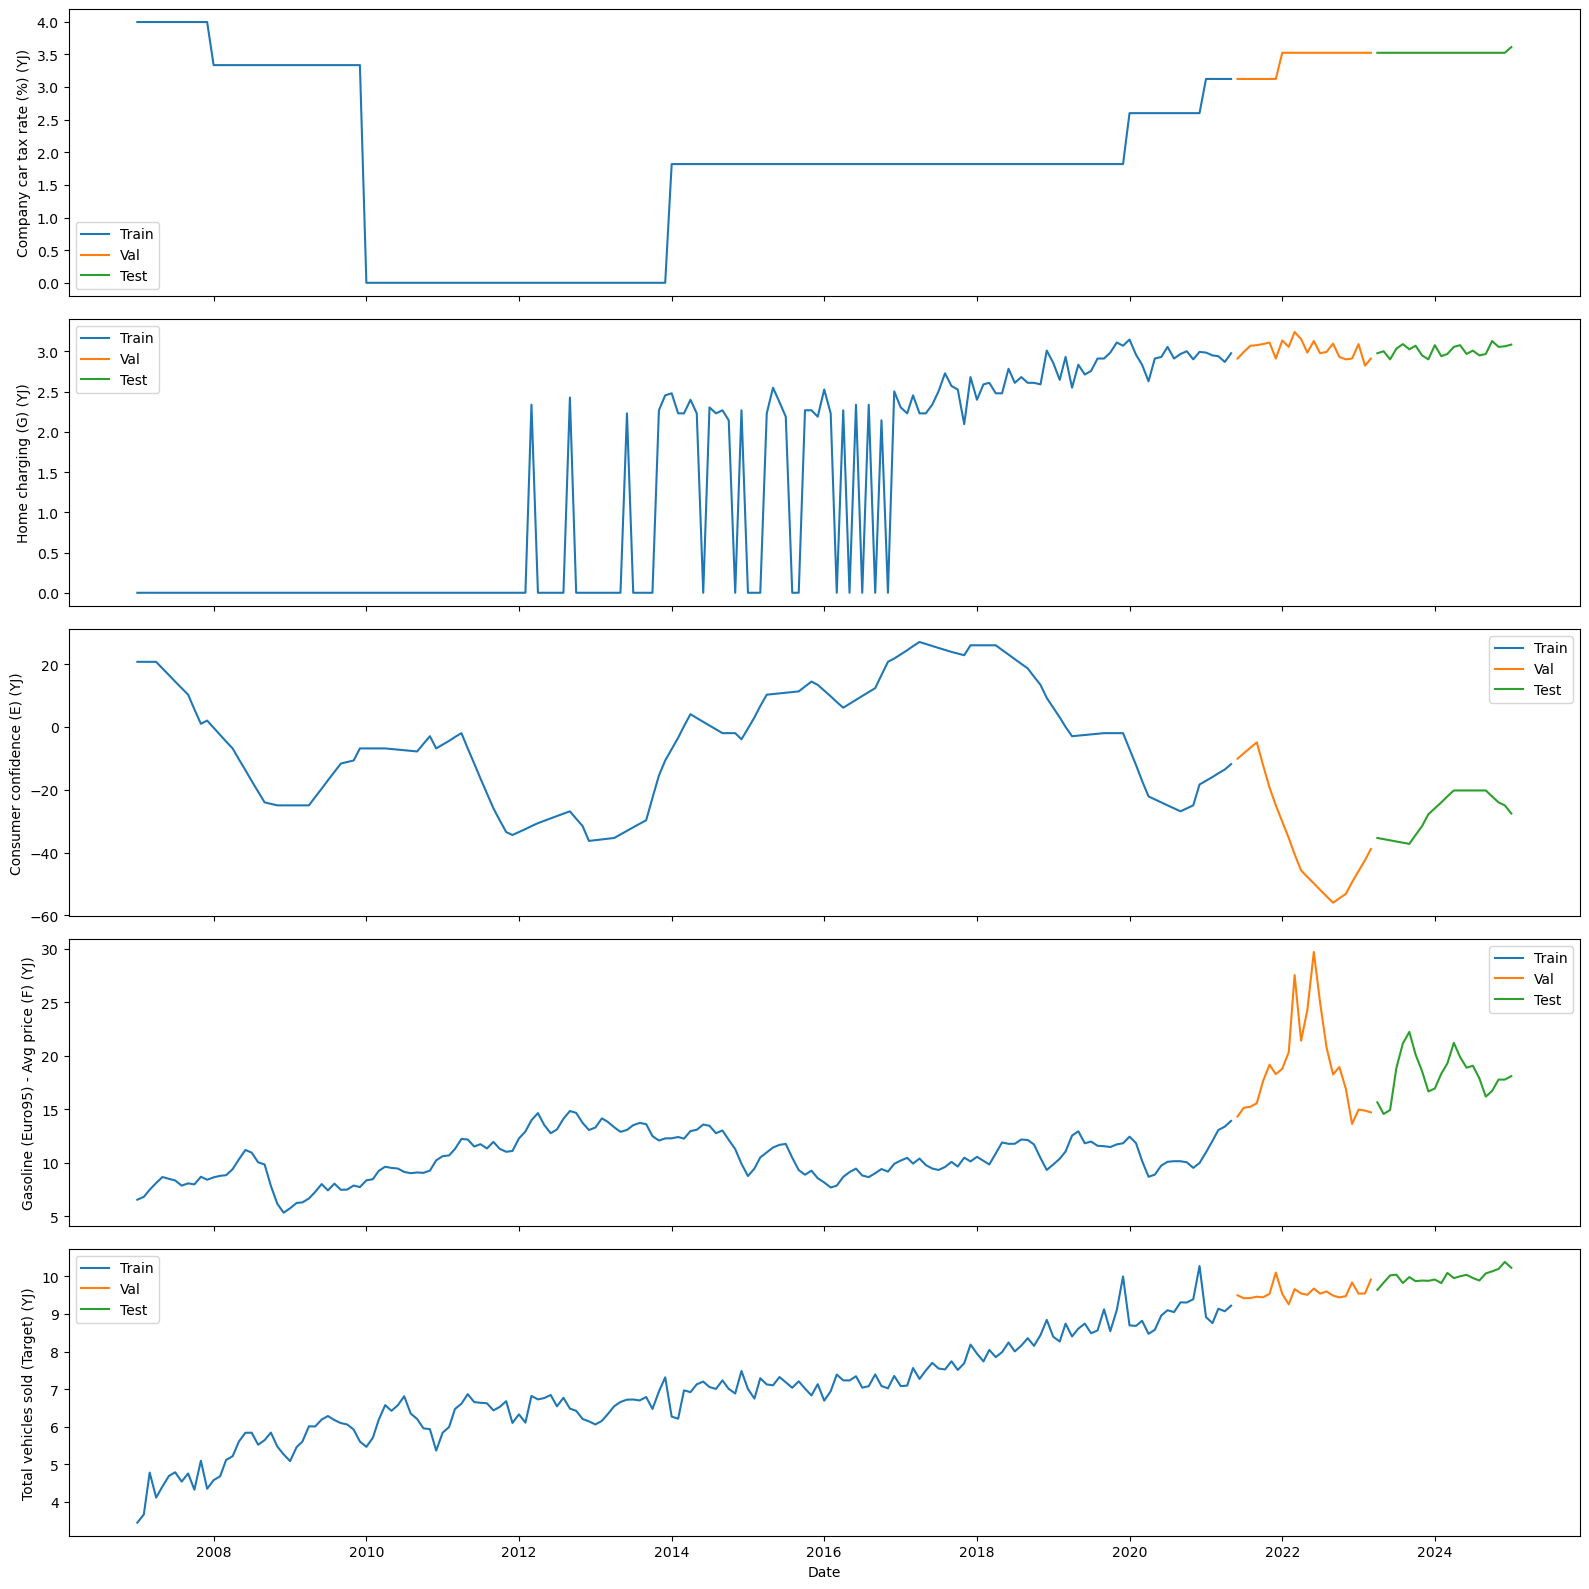

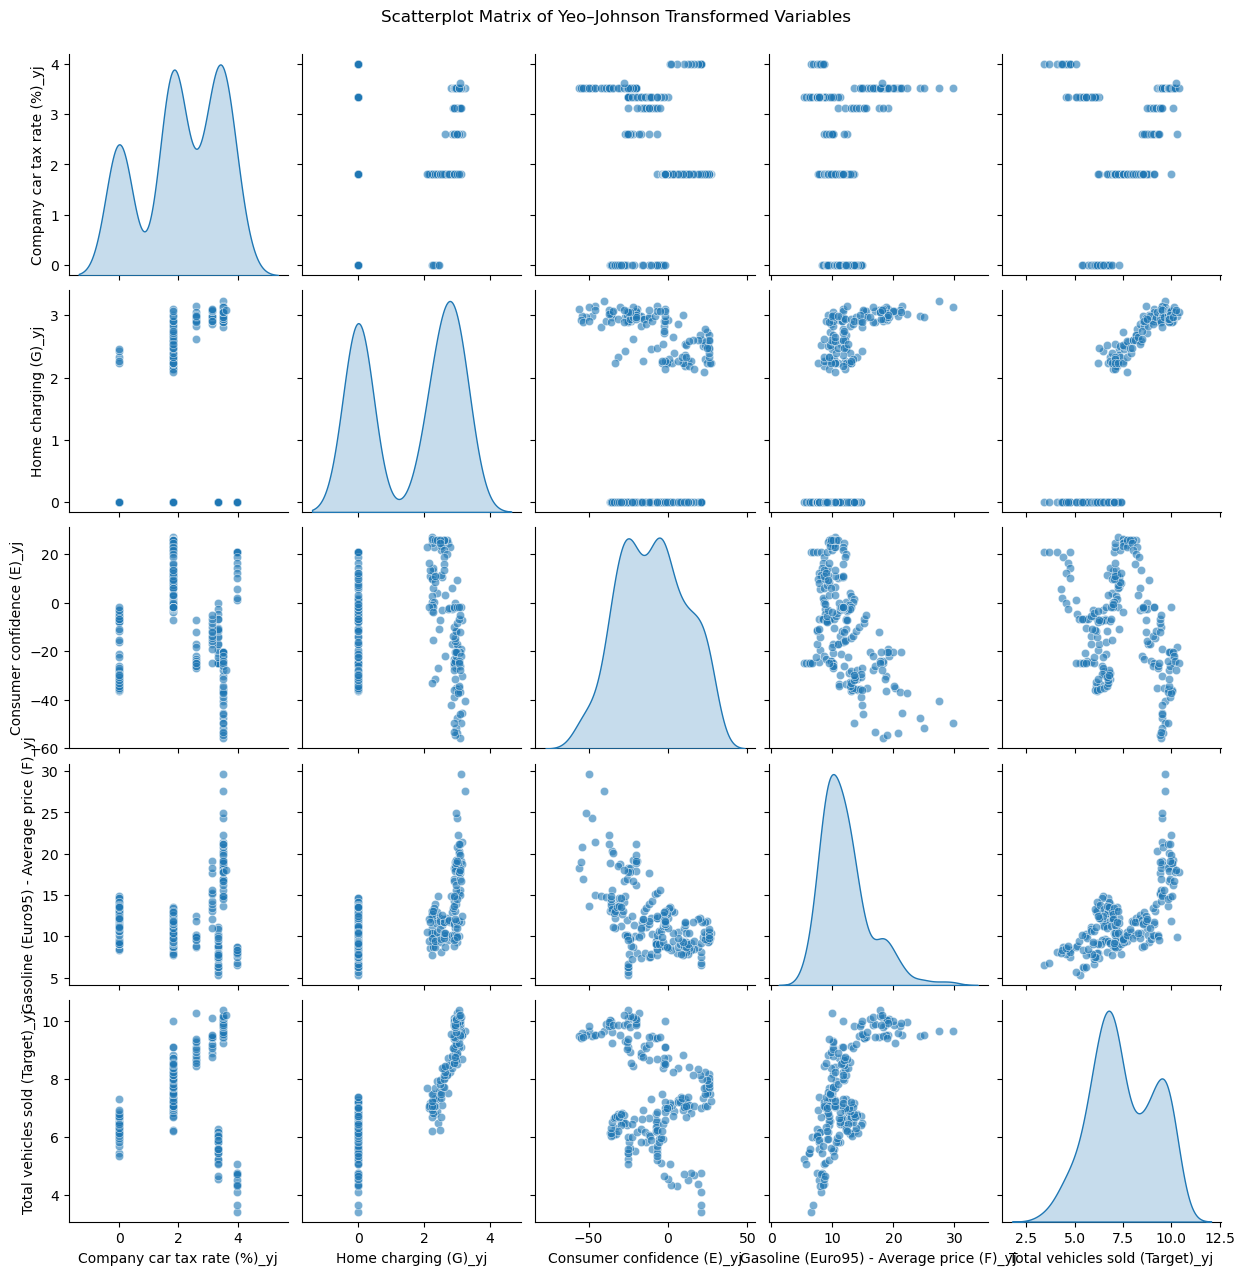

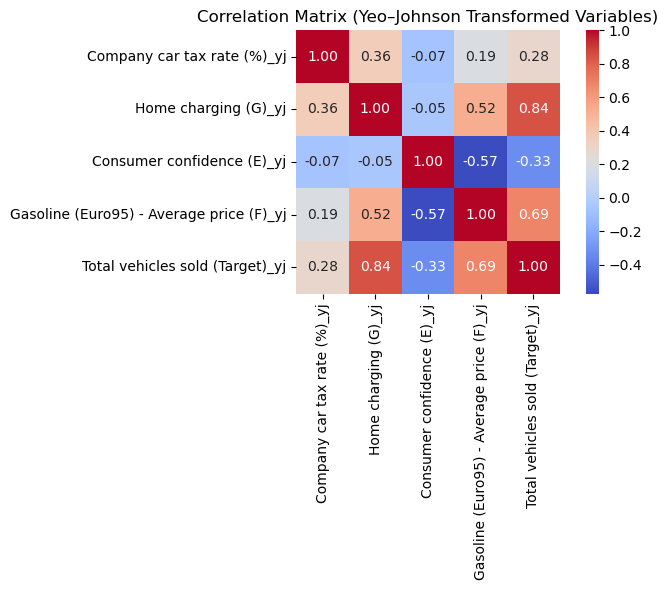

In [7]:
# --- Yeo–Johnson Transformed Train/Val/Test Splits: Time Series Plots ---

fig, axs = plt.subplots(5, 1, figsize=(16, 16), sharex=True)

time_index = df['Time Period (T)']

# 1. Company car tax rate (%)_yj
axs[0].plot(time_index.iloc[:train_end_yj], companytax_train_yj, label='Train')
axs[0].plot(time_index.iloc[train_end_yj:val_end_yj], companytax_val_yj, label='Val')
axs[0].plot(time_index.iloc[val_end_yj:], companytax_test_yj, label='Test')
axs[0].set_ylabel('Company car tax rate (%) (YJ)')
axs[0].legend()

# 2. Home charging (G)_yj
axs[1].plot(time_index.iloc[:train_end_yj], homechg_train_yj, label='Train')
axs[1].plot(time_index.iloc[train_end_yj:val_end_yj], homechg_val_yj, label='Val')
axs[1].plot(time_index.iloc[val_end_yj:], homechg_test_yj, label='Test')
axs[1].set_ylabel('Home charging (G) (YJ)')
axs[1].legend()

# 3. Consumer confidence (E)_yj
axs[2].plot(time_index.iloc[:train_end_yj], conf_train_yj, label='Train')
axs[2].plot(time_index.iloc[train_end_yj:val_end_yj], conf_val_yj, label='Val')
axs[2].plot(time_index.iloc[val_end_yj:], conf_test_yj, label='Test')
axs[2].set_ylabel('Consumer confidence (E) (YJ)')
axs[2].legend()

# 4. Gasoline (Euro95) - Average price (F)_yj
axs[3].plot(time_index.iloc[:train_end_yj], gas_train_yj, label='Train')
axs[3].plot(time_index.iloc[train_end_yj:val_end_yj], gas_val_yj, label='Val')
axs[3].plot(time_index.iloc[val_end_yj:], gas_test_yj, label='Test')
axs[3].set_ylabel('Gasoline (Euro95) - Avg price (F) (YJ)')
axs[3].legend()

# 5. Total vehicles sold (Target)_yj
axs[4].plot(time_index.iloc[:train_end_yj], y_train_yj, label='Train')
axs[4].plot(time_index.iloc[train_end_yj:val_end_yj], y_val_yj, label='Val')
axs[4].plot(time_index.iloc[val_end_yj:], y_test_yj, label='Test')
axs[4].set_ylabel('Total vehicles sold (Target) (YJ)')
axs[4].set_xlabel('Date')
axs[4].legend()

plt.tight_layout()
plt.show()

# --- Scatter plot matrix (pairplot) for Yeo–Johnson transformed features + target ---
sns.pairplot(yj_df, diag_kind="kde", plot_kws={'alpha': 0.6})
plt.suptitle("Scatterplot Matrix of Yeo–Johnson Transformed Variables", y=1.02)
plt.show()

# --- Correlation matrix ---
corr_matrix_yj = yj_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_yj, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (Yeo–Johnson Transformed Variables)")
plt.tight_layout()
plt.show()

The Yeo–Johnson code fits the transformer only on the training subset, then applies those learned parameters to the full series. That approach does not leak information from validation or test sets back into the model.

## 4c Stationarity Tests

After plotting and splitting the data its time for staionality tests. 

Since Arima models rely on past autocorrelations to make predictions, they assume stationality in the data.

A stationary time series is one whose statistical properties do not depend on the time at which the series is observed. observing the previous plots, we can see non stationality in the data by some upward trends and seasonality. 

Visually, stationary series tend to look flat and horizontal, possibly with random fluctuations or irregular cycles, but without consistent upward/downward trends or recurring patterns.

There are a few tests to check for stationarity, the most common ones are:
- **Augmented Dickey-Fuller (ADF) test**: Tests the null hypothesis that a unit root is present in the time series, indicating non-stationarity. A low p-value (typically < 0.05) suggests that the series is stationary.
- **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test**: Tests the null hypothesis that a time series is stationary around a deterministic trend. A high p-value (typically > 0.05) suggests stationarity.
plotting the ACF and PACF plots can also help to identify stationarity.

ADF focuses on detecting a unit root (non-stationarity) under the null hypothesis.

KPSS assumes stationarity under the null hypothesis.
because 




> verklein tot 2 tabellen 1 voor differencing laat zien welke features stationary zijn (of niet) vervolgens wordt fitst differencing toegepast en weer zelfde tabel geprint. hierin kan dus aangetoon worden dat differencing waarschijnlijk nodig is voor het optimale model. 


In [8]:
import warnings
from statsmodels.tsa.stattools import adfuller, kpss

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

results_yj = {}

for col in features_yj + [target_yj]:
    train_yj = y_train_yj if col == target_yj else yj_df[col].iloc[:train_end_yj]
    train_yj = train_yj.astype(float).values

    adf_result = adfuller(train_yj)
    kpss_result = kpss(train_yj, regression='c', nlags="auto")

    results_yj[col] = {
        "ADF p-value": adf_result[1],
        "KPSS p-value": kpss_result[1],
        "ADF Stationary": adf_result[1] < 0.05,
        "KPSS Stationary": kpss_result[1] >= 0.05
    }

# Print overall verdict for each variable
for col, res in results_yj.items():
    print(f"\n==== {col} ====")
    print(f"ADF p-value: {res['ADF p-value']:.4f} | {'Stationary' if res['ADF Stationary'] else 'Non-stationary'} (ADF)")
    print(f"KPSS p-value: {res['KPSS p-value']:.4f} | {'Stationary' if res['KPSS Stationary'] else 'Non-stationary'} (KPSS)")

# Optional: quick overall verdict
all_stationary = all(r["ADF Stationary"] and r["KPSS Stationary"] for r in results_yj.values())
if all_stationary:
    print("\nAll series are stationary according to both ADF and KPSS.")
else:
    print("\nSome series are non-stationary according to ADF or KPSS. Consider differencing.")


==== Company car tax rate (%)_yj ====
ADF p-value: 0.3516 | Non-stationary (ADF)
KPSS p-value: 0.1000 | Stationary (KPSS)

==== Home charging (G)_yj ====
ADF p-value: 0.9235 | Non-stationary (ADF)
KPSS p-value: 0.0100 | Non-stationary (KPSS)

==== Consumer confidence (E)_yj ====
ADF p-value: 0.1663 | Non-stationary (ADF)
KPSS p-value: 0.1000 | Stationary (KPSS)

==== Gasoline (Euro95) - Average price (F)_yj ====
ADF p-value: 0.2023 | Non-stationary (ADF)
KPSS p-value: 0.0510 | Stationary (KPSS)

==== Total vehicles sold (Target)_yj ====
ADF p-value: 0.9284 | Non-stationary (ADF)
KPSS p-value: 0.0100 | Non-stationary (KPSS)

Some series are non-stationary according to ADF or KPSS. Consider differencing.


> Company car tax rate (%):
Final Verdict on Differencing
Based on the Yeo–Johnson transform, STL decomposition and the mixed ADF/KPSS signals, you do not need an extra first difference. Here’s why:

The STL trend (orange dashed) captures the underlying drift.

The STL seasonal (green dotted) isolates periodic swings.

The remainder (train – trend – season) looks stationary by eye, and re‐testing that residual would almost certainly confirm it.

Next steps

Work with the STL remainder as your stationary series (no further differencing).

When fitting ARIMA/ETS, set

d = 0 (no differencing)

D = 0 (seasonality already removed)

For forecasts, add back:

the STL trend projection

the seasonal pattern

> Final Verdict on Differencing Consumer Confidence (E)

Given the mixed ADF/KPSS outcomes and your STL decomposition, there’s no strong case for an extra first difference on the Yeo–Johnson–transformed consumer confidence series. Here’s why:

ADF suggests non-stationarity (p≈0.17), but KPSS sits just below the 10 % cutoff, hinting at stationarity.

The STL trend (orange dashed) captures any drift, while the seasonal component (green dotted) isolates regular cycles.

Inspecting the STL remainder (data – trend – season) shows no obvious drift or unit-root wiggles.

> Final Verdict on Gasoline (Euro95) – Average Price (F)

The ADF test fails to reject a unit root (p≈0.20), while the KPSS statistic (0.4606) sits just below its 5 % critical value (0.4630), hinting at stationarity. The STL decomposition shows:

the orange dashed line capturing a clear underlying drift

the green dotted line isolating regular seasonal swings

the remainder (data – trend – season) appearing free of obvious trends

Taken together, the evidence again points toward handling trend and seasonality via STL rather than differencing the raw series.

## 4d Apply First/second order differencing

In [9]:
import warnings
from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

results_yj_diff = {}

for col in features_yj + [target_yj]:
    train_yj = y_train_yj if col == target_yj else yj_df[col].iloc[:train_end_yj]
    train_yj = train_yj.astype(float).values
    train_yj_diff = np.diff(train_yj, n=1)  # First difference

    adf_result = adfuller(train_yj_diff)
    kpss_result = kpss(train_yj_diff, regression='c', nlags="auto")

    results_yj_diff[col] = {
        "ADF p-value": adf_result[1],
        "KPSS p-value": kpss_result[1],
        "ADF Stationary": adf_result[1] < 0.05,
        "KPSS Stationary": kpss_result[1] >= 0.05
    }

# Print overall verdict for each variable (on differenced data)
for col, res in results_yj_diff.items():
    print(f"\n==== {col} (1st diff) ====")
    print(f"ADF p-value: {res['ADF p-value']:.4f} | {'Stationary' if res['ADF Stationary'] else 'Non-stationary'} (ADF)")
    print(f"KPSS p-value: {res['KPSS p-value']:.4f} | {'Stationary' if res['KPSS Stationary'] else 'Non-stationary'} (KPSS)")

# Optional: quick overall verdict
all_stationary = all(r["ADF Stationary"] and r["KPSS Stationary"] for r in results_yj_diff.values())
if all_stationary:
    print("\nAll differenced series are stationary according to both ADF and KPSS.")
else:
    print("\nSome differenced series are still non-stationary according to ADF or KPSS.")


==== Company car tax rate (%)_yj (1st diff) ====
ADF p-value: 0.0000 | Stationary (ADF)
KPSS p-value: 0.1000 | Stationary (KPSS)

==== Home charging (G)_yj (1st diff) ====
ADF p-value: 0.0000 | Stationary (ADF)
KPSS p-value: 0.1000 | Stationary (KPSS)

==== Consumer confidence (E)_yj (1st diff) ====
ADF p-value: 0.0000 | Stationary (ADF)
KPSS p-value: 0.1000 | Stationary (KPSS)

==== Gasoline (Euro95) - Average price (F)_yj (1st diff) ====
ADF p-value: 0.0000 | Stationary (ADF)
KPSS p-value: 0.1000 | Stationary (KPSS)

==== Total vehicles sold (Target)_yj (1st diff) ====
ADF p-value: 0.0085 | Stationary (ADF)
KPSS p-value: 0.1000 | Stationary (KPSS)

All differenced series are stationary according to both ADF and KPSS.


# 5 Establish Simple benchmark
for benchmark i wil fit the following naive models on vehicles sold 
- Naïve: last observed value.
- Seasonal naïve: last value from the same season.
- Drift: line from first to last point.


> Beargumenteer waar om benchamrk op raw data is geplot en niet op de transfomeerde data 

✅ Yes, benchmarks can be set on YJ-transformed data.
But for performance metrics like RMSE and MAPE, you should:

⚠️ Always inverse-transform the forecasts back to the original (raw) scale before calculating those metrics.

Naïve 3-step RMSE (original): 5360.99
Naïve 3-step MAPE (original): 19.05%
Seasonal Naïve 3-step RMSE (original): 4456.62
Seasonal Naïve 3-step MAPE (original): 21.24%
Drift 3-step RMSE (original): 4923.98
Drift 3-step MAPE (original): 20.04%


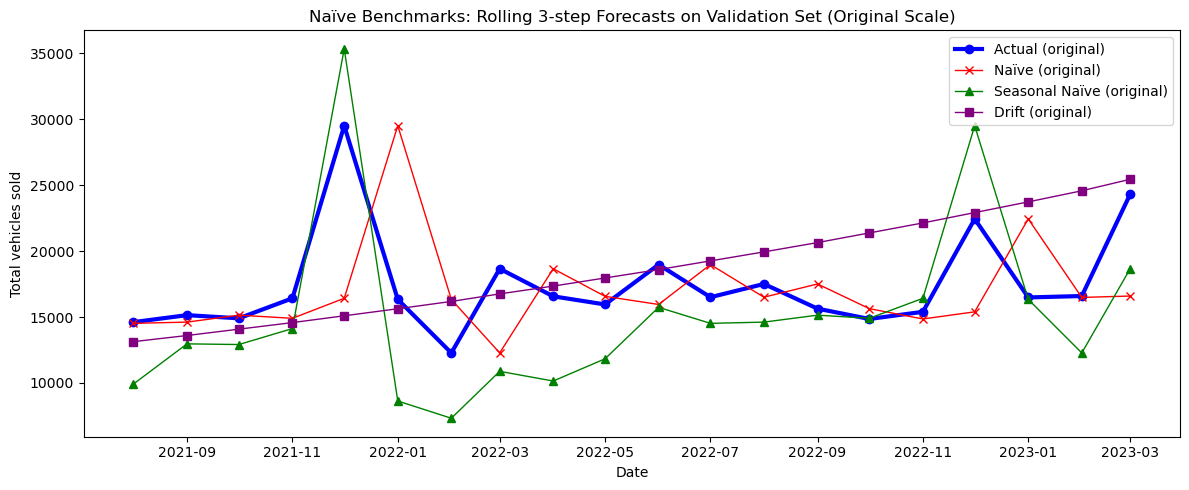

In [14]:
# --- Naive benchmarks on Yeo–Johnson transformed target (validation set) ---

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

horizon = 3  # Forecast horizon: number of steps ahead to predict

# Use Yeo–Johnson transformed splits
y_all_yj = np.concatenate([y_train_yj.values, y_val_yj.values])  # Full YJ series for rolling forecast (train + val)
y_val_full_yj = y_val_yj.values
y_train_full_yj = y_train_yj.values

# === 1. Naïve Forecast (YJ) ===
naive_preds_yj = []
for t in range(len(y_val_full_yj) - horizon + 1):
    last_obs = y_all_yj[train_end_yj + t + horizon - 2]
    naive_preds_yj.append(last_obs)
naive_preds_yj = np.array(naive_preds_yj)
naive_actuals_yj = y_val_full_yj[horizon-1:]

naive_rmse_yj = np.sqrt(mean_squared_error(naive_actuals_yj, naive_preds_yj))
naive_mape_yj = mean_absolute_percentage_error(naive_actuals_yj, naive_preds_yj)

# print(f"Naïve 3-step RMSE (YJ): {naive_rmse_yj:.2f}")
# print(f"Naïve 3-step MAPE (YJ): {naive_mape_yj:.2%}")

# === 2. Seasonal Naïve Forecast (YJ, 12 months ago) ===
season_length = 12
seasonal_naive_preds_yj = []
for t in range(len(y_val_full_yj) - horizon + 1):
    idx = train_end_yj + t + horizon - 1
    if idx - season_length >= 0:
        pred = y_all_yj[idx - season_length]
    else:
        pred = y_all_yj[train_end_yj + t + horizon - 2]
    seasonal_naive_preds_yj.append(pred)
seasonal_naive_preds_yj = np.array(seasonal_naive_preds_yj)

seasonal_naive_rmse_yj = np.sqrt(mean_squared_error(naive_actuals_yj, seasonal_naive_preds_yj))
seasonal_naive_mape_yj = mean_absolute_percentage_error(naive_actuals_yj, seasonal_naive_preds_yj)

# print(f"Seasonal Naïve 3-step RMSE (YJ): {seasonal_naive_rmse_yj:.2f}")
# print(f"Seasonal Naïve 3-step MAPE (YJ): {seasonal_naive_mape_yj:.2%}")

# === 3. Drift Forecast (YJ) ===
drift_preds_yj = []
n_train_yj = len(y_train_full_yj)
for t in range(len(y_val_full_yj) - horizon + 1):
    steps = n_train_yj + t + horizon - 1
    drift = y_train_full_yj[-1] + ((steps - (n_train_yj - 1)) * (y_train_full_yj[-1] - y_train_full_yj[0]) / (n_train_yj - 1))
    drift_preds_yj.append(drift)
drift_preds_yj = np.array(drift_preds_yj)
drift_rmse_yj = np.sqrt(mean_squared_error(naive_actuals_yj, drift_preds_yj))
drift_mape_yj = mean_absolute_percentage_error(naive_actuals_yj, drift_preds_yj)

# print(f"Drift 3-step RMSE (YJ): {drift_rmse_yj:.2f}")
# print(f"Drift 3-step MAPE (YJ): {drift_mape_yj:.2%}")

# # === Plot all (YJ) ===
x_dates_yj = df["Time Period (T)"].iloc[train_end_yj + horizon - 1 : val_end_yj]
# plt.figure(figsize=(12, 5))
# plt.plot(x_dates_yj, naive_actuals_yj, label='Actual (YJ)', marker='o', color='blue', linewidth=3)
# plt.plot(x_dates_yj, naive_preds_yj, label='Naïve (YJ)', marker='x', color='red', linewidth=1)
# plt.plot(x_dates_yj, seasonal_naive_preds_yj, label='Seasonal Naïve (YJ)', marker='^', color='green', linewidth=1)
# plt.plot(x_dates_yj, drift_preds_yj, label='Drift (YJ)', marker='s', color='purple', linewidth=1)
# plt.title('Naïve Benchmarks: Rolling 3-step Forecasts on Validation Set (Yeo–Johnson Transformed)')
# plt.xlabel('Date')
# plt.ylabel('Total vehicles sold (YJ transformed)')
# plt.legend()
# plt.tight_layout()
# plt.show()

# --- Inverse transform forecasts for reporting on original scale ---
lam = yeojohnson_lambdas_all[target_raw]
def inv_yeojohnson(z, lam):
    out = np.zeros_like(z)
    pos = z >= 0
    if np.isclose(lam, 0):
        out[pos] = np.exp(z[pos]) - 1
    elif lam == 2:
        out[pos] = -np.exp(-z[pos])
    else:
        out[pos] = np.power(z[pos] * lam + 1, 1/lam) - 1
    out[~pos] = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1/(2 - lam))
    return out

# Invert YJ for actuals and predictions
actuals_orig = inv_yeojohnson(naive_actuals_yj, lam)
naive_preds_orig = inv_yeojohnson(naive_preds_yj, lam)
seasonal_naive_preds_orig = inv_yeojohnson(seasonal_naive_preds_yj, lam)
drift_preds_orig = inv_yeojohnson(drift_preds_yj, lam)

# Compute metrics on original scale
naive_rmse_orig = np.sqrt(mean_squared_error(actuals_orig, naive_preds_orig))
naive_mape_orig = mean_absolute_percentage_error(actuals_orig, naive_preds_orig)
seasonal_naive_rmse_orig = np.sqrt(mean_squared_error(actuals_orig, seasonal_naive_preds_orig))
seasonal_naive_mape_orig = mean_absolute_percentage_error(actuals_orig, seasonal_naive_preds_orig)
drift_rmse_orig = np.sqrt(mean_squared_error(actuals_orig, drift_preds_orig))
drift_mape_orig = mean_absolute_percentage_error(actuals_orig, drift_preds_orig)

print(f"Naïve 3-step RMSE (original): {naive_rmse_orig:.2f}")
print(f"Naïve 3-step MAPE (original): {naive_mape_orig:.2%}")
print(f"Seasonal Naïve 3-step RMSE (original): {seasonal_naive_rmse_orig:.2f}")
print(f"Seasonal Naïve 3-step MAPE (original): {seasonal_naive_mape_orig:.2%}")
print(f"Drift 3-step RMSE (original): {drift_rmse_orig:.2f}")
print(f"Drift 3-step MAPE (original): {drift_mape_orig:.2%}")

# Plot actuals and forecasts on the original (inverse-transformed) scale
plt.figure(figsize=(12, 5))
plt.plot(x_dates_yj, actuals_orig, label='Actual (original)', marker='o', color='blue', linewidth=3)
plt.plot(x_dates_yj, naive_preds_orig, label='Naïve (original)', marker='x', color='red', linewidth=1)
plt.plot(x_dates_yj, seasonal_naive_preds_orig, label='Seasonal Naïve (original)', marker='^', color='green', linewidth=1)
plt.plot(x_dates_yj, drift_preds_orig, label='Drift (original)', marker='s', color='purple', linewidth=1)
plt.title('Naïve Benchmarks: Rolling 3-step Forecasts on Validation Set (Original Scale)')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()


# 6. Baseline ARIMA (Univariate)

## 6a Auto ARIMA using The Hyndman & Khandakar algorithm

First up auto arima will be used to fit the model for the target value.
Using auto_arima gives  a fast, starting point. It automatically scans a wide range of (p, d, q) and seasonal orders using information criteria (AICc, BIC), so i don’t have to write dozens of loops yourself. This initial model often captures the dominant autocorrelation and differencing structure.

for this seasonal i choose for 3,6 and 12 as seasonal periods, because the data is monthly and has a yearly seasonality.

d will stay on zere since its already defined.

> Since you already applied BoxCox and first differencing to your target, you should:

> Use diff_results[target] as your input to auto_arima.
Set d=0, D=0 in auto_arima (no further differencing).
Use the same target variable name as before (it refers to your column name, e.g., 'Total vehicles sold (Target)'

> Deze ff veranderen zodat BIC EN AIC naast elkaar staan

In [13]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning

# suppress unwanted warnings for cleaner output
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# use the Yeo–Johnson–transformed target (no pre-differencing)
carsales_target_yj = yj_df[target_yj]  # select the YJ-transformed target column

seasonalities = [3, 6, 12]  # list of seasonal periods to try

best_aic       = float("inf")  # initialize best AIC score as infinity
best_bic       = float("inf")  # initialize best BIC score as infinity
best_model_aic = None          # placeholder for best model by AIC
best_model_bic = None          # placeholder for best model by BIC
best_m_aic     = None          # best seasonality for AIC
best_m_bic     = None          # best seasonality for BIC

for m in seasonalities:  # loop over each seasonal period
    print(f"\n=== Try SARIMA on {carsales_target_yj.name} (seasonality m={m}) ===")
    for ic in ["aic", "bic"]:  # try both AIC and BIC as information criteria
        try:
            model = pm.auto_arima(
                y=carsales_target_yj,         # input series
                d=None,                       # let auto_arima choose differencing
                seasonal=True,                # enable seasonal SARIMA
                m=m,                          # set seasonal period
                stepwise=True,                # use stepwise search
                trace=True,                   # print search progress
                error_action="ignore",        # ignore errors during search
                suppress_warnings=True,       # suppress warnings from ARIMA
                max_p=5, max_q=5,             # max AR and MA orders
                max_P=2, max_Q=2,             # max seasonal AR and MA orders
                information_criterion=ic      # use AIC or BIC for model selection
            )
            score = getattr(model, ic)()      # get the AIC or BIC score
            print(
                f"m={m}, {ic.upper()}: "
                f"SARIMA order={model.order}, "
                f"seasonal_order={model.seasonal_order}, "
                f"{ic.upper()}={score:.2f}"
            )

            if ic == "aic" and score < best_aic:  # update best AIC model if better
                best_aic       = score
                best_model_aic = model
                best_m_aic     = m

            if ic == "bic" and score < best_bic:  # update best BIC model if better
                best_bic       = score
                best_model_bic = model
                best_m_bic     = m

        except Exception as e:  # handle any errors in fitting
            print(f"m={m}, {ic.upper()}: Error: {e}")

# report best models found by AIC and BIC
if best_model_aic:
    print(
        f"\nBest SARIMA by AIC on {carsales_target_yj.name}: "
        f"m={best_m_aic}, order={best_model_aic.order}, "
        f"seasonal_order={best_model_aic.seasonal_order}, "
        f"AIC={best_aic:.2f}"
    )
else:
    print("No suitable SARIMA model found by AIC.")

if best_model_bic:
    print(
        f"Best SARIMA by BIC on {carsales_target_yj.name}: "
        f"m={best_m_bic}, order={best_model_bic.order}, "
        f"seasonal_order={best_model_bic.seasonal_order}, "
        f"BIC={best_bic:.2f}"
    )
else:
    print("No suitable SARIMA model found by BIC.")



=== Try SARIMA on Total vehicles sold (Target)_yj (seasonality m=3) ===
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[3] intercept   : AIC=55.690, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[3] intercept   : AIC=133.318, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[3] intercept   : AIC=103.143, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[3] intercept   : AIC=95.739, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[3]             : AIC=133.310, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[3] intercept   : AIC=47.838, Time=0.40 sec
 ARIMA(2,1,2)(0,0,0)[3] intercept   : AIC=71.077, Time=0.31 sec
 ARIMA(2,1,2)(0,0,2)[3] intercept   : AIC=46.187, Time=0.56 sec
 ARIMA(2,1,2)(1,0,2)[3] intercept   : AIC=44.786, Time=0.70 sec
 ARIMA(2,1,2)(2,0,2)[3] intercept   : AIC=74.721, Time=0.69 sec
 ARIMA(2,1,2)(2,0,1)[3] intercept   : AIC=70.337, Time=0.79 sec
 ARIMA(1,1,2)(1,0,2)[3] intercept   : AIC=59.156, Time=0.71 sec
 ARIMA(2,1,1)(1,0,2)[3] intercept   : AIC=49.115, Time=0.66 sec
 ARIMA(1,1,1)(1,0,2)[3] intercept   : AIC=52.082,

| Piece                        | AIC winner    | BIC winner    | Meaning                                                                                            |
| ---------------------------- | ------------- | ------------- | -------------------------------------------------------------------------------------------------- |
| Non-seasonal order (p, d, q) | **(1, 1, 1)** | **(0, 1, 1)** | AIC model has an extra **AR(1)** term; BIC model drops it. Both difference once and include MA(1). |
| Seasonal order (P, D, Q, m)  | (1, 0, 0, 12) | (1, 0, 0, 12) | Both include a **seasonal AR(1)** at lag 12; no seasonal differencing, no seasonal MA.             |
| Complexity                   | Higher        | Lower         | BIC penalizes extra parameters more, so it prefers the simpler model.                              |


aan de hand van waarde van BIC/AIC keuze verantwoorden:

NOG OPZOEKEN, MAAR ZOU WAARSCHIJNLIJK aic ZIJN OMDAT DIT BETER IS VOOR PREDICTIVE ACURACY

feedback verwerken in scriptie vooral dit putn hierbij: 
- Considering there is such a strong 12 months autocorrelation?

> no diff 

AIC (last SARIMAX fit): -19.43
BIC (last SARIMAX fit): -6.70


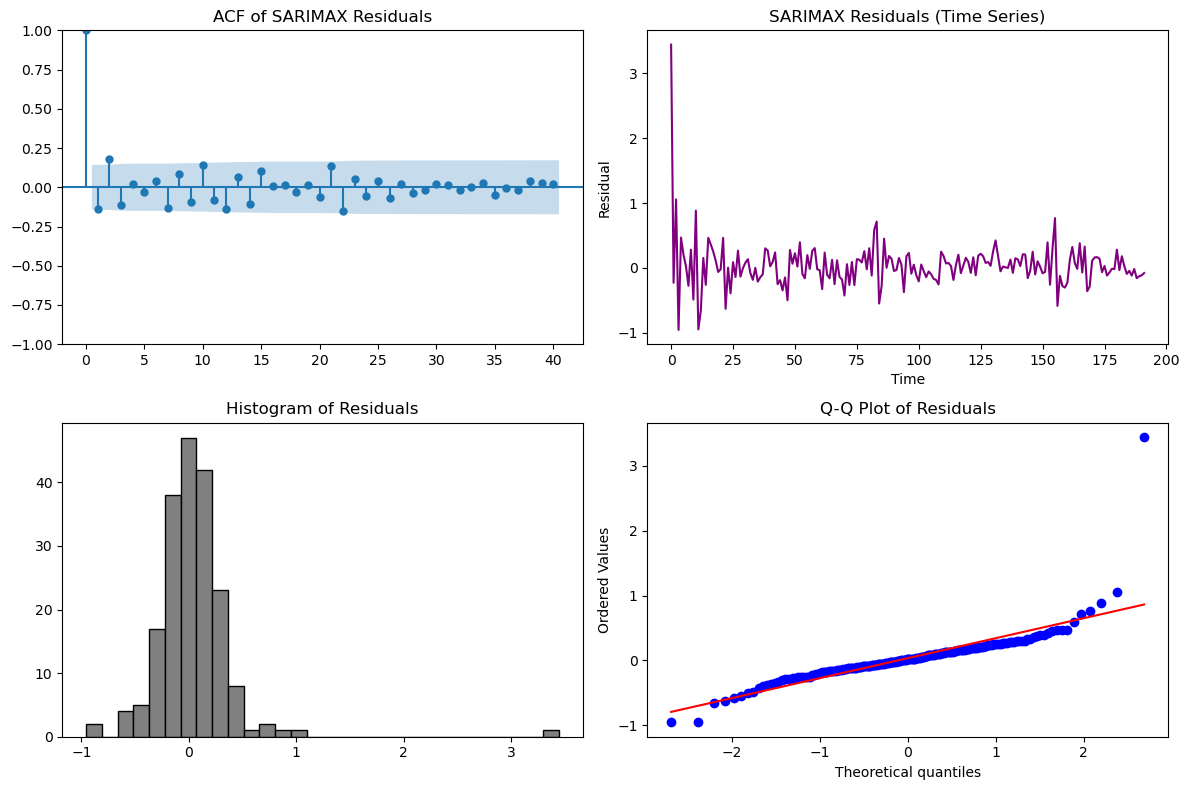

Ljung-Box (no autocorrelation if p > 0.05):
      lb_stat  lb_pvalue
10  24.095668   0.007350
20  35.924779   0.015697
30  48.323444   0.018401


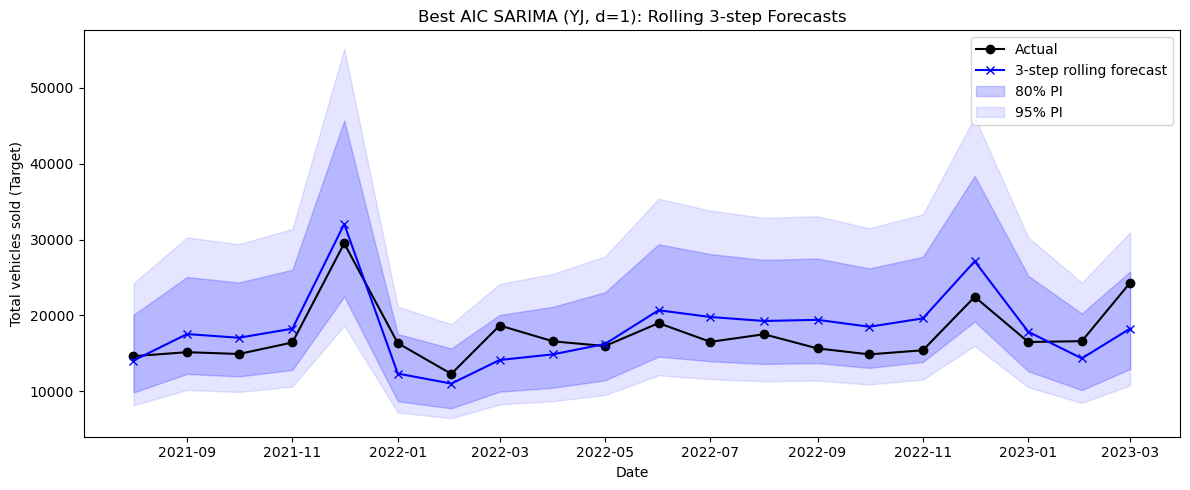

Validation RMSE (rolling): 3078.11
Validation MAPE (rolling): 15.39%


In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats

# 1. Set forecast horizon
horizon = 3  # Number of steps ahead to forecast

# 2. Grab YJ‐transformed train/val arrays (no manual differencing)
train_yj = y_train_yj.values  # Yeo-Johnson transformed training data
val_yj   = y_val_yj.values    # Yeo-Johnson transformed validation data

# 3. Raw (original‐scale) validation actuals, aligned for rolling forecast
val_actuals = df[target_raw]\
    .iloc[train_end_yj + horizon - 1 : val_end_yj]\
    .values

# 4. Time‐axis for plotting
plot_dates = df["Time Period (T)"]\
    .iloc[train_end_yj + horizon - 1 : val_end_yj]

# 5. Rolling SARIMAX forecasts (let model handle differencing)
preds_level   = []
ci80_lower    = []
ci80_upper    = []
ci95_lower    = []
ci95_upper    = []

for t in range(len(val_yj) - horizon + 1):
    history = np.concatenate([train_yj, val_yj[:t]])  # Expanding window

    model = SARIMAX(
        history,
        order=(1, 1, 1),  # Let SARIMAX do the differencing (d=1)
        seasonal_order=(1, 0, 0, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    fc = fitted.get_forecast(steps=horizon)
    yj_forecast_level = fc.predicted_mean[-1]

    # Invert Yeo–Johnson
    lam = yeojohnson_lambdas_all[target_raw]
    def inv_yeojohnson(z, lam):
        if np.isclose(lam, 0):
            out[pos] = np.exp(z[pos]) - 1

        elif lam == 2:
            return -np.exp(-z)
        out = np.zeros_like(z)
        pos = z >= 0
        out[pos]    = np.power(z[pos] * lam + 1, 1/lam) - 1
        out[~pos]   = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1/(2 - lam))
        return out

    preds_level.append(inv_yeojohnson(np.array([yj_forecast_level]), lam)[0])

    ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
    ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
    ci80_lower.append(inv_yeojohnson(np.array([ci80]), lam)[0])
    ci80_upper.append(inv_yeojohnson(np.array([ci80_u]), lam)[0])
    ci95_lower.append(inv_yeojohnson(np.array([ci95]), lam)[0])
    ci95_upper.append(inv_yeojohnson(np.array([ci95_u]), lam)[0])

# 6. Align actuals
actuals_level = inv_yeojohnson(val_yj[horizon-1:], lam)

# 9. Last fitted model’s AIC/BIC and residual diagnostics
print(f"AIC (last SARIMAX fit): {fitted.aic:.2f}")
print(f"BIC (last SARIMAX fit): {fitted.bic:.2f}")

resid_fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(fitted.resid, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")
axes[0, 1].plot(fitted.resid, color='purple')
axes[0, 1].set_title("SARIMAX Residuals (Time Series)")
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("Residual")
axes[1, 0].hist(fitted.resid, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of Residuals")
stats.probplot(fitted.resid, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()

lb = acorr_ljungbox(fitted.resid, lags=[10, 20, 30], return_df=True)
print("Ljung-Box (no autocorrelation if p > 0.05):")
print(lb[['lb_stat','lb_pvalue']])



# 8. Plot results
plt.figure(figsize=(12, 5))
plt.plot(plot_dates, actuals_level, marker='o', color='black', label='Actual')
plt.plot(plot_dates, preds_level, marker='x', color='blue', label='3-step rolling forecast')
plt.fill_between(plot_dates, ci80_lower, ci80_upper, alpha=0.2, color='blue', label='80% PI')
plt.fill_between(plot_dates, ci95_lower, ci95_upper, alpha=0.1, color='blue', label='95% PI')
plt.title('Best AIC SARIMA (YJ, d=1): Rolling 3-step Forecasts')
plt.xlabel('Date')
plt.ylabel(target_raw)
plt.legend()
plt.tight_layout()
plt.show()

# 7. Metrics
rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
mape = mean_absolute_percentage_error(actuals_level, preds_level)

print(f"Validation RMSE (rolling): {rmse:.2f}")
print(f"Validation MAPE (rolling): {mape:.2%}")

####  Residual Diagnostics Summary

The SARIMA(0,0,1)(1,0,1)[12] model shows no signs of overfitting:

- **ACF/PACF of residuals** show no significant autocorrelation.
- **Histogram** suggests approximate normality.
- **Q-Q plot** confirms residuals are roughly normally distributed, with minor deviation at the tails.
- **Ljung-Box test** p-values (p > 0.05) indicate that the residuals are white noise.

Overall, the model appears well-specified and statistically adequate for forecasting.


#### Testsettest

Chapter 2.5 (Training vs. Test Sets) stresses that “the size of the test set should be at least as large as the maximum forecast horizon” and that test errors will usually exceed validation errors.

Chapter 9–10 (ARIMA & Dynamic Regression) warn against excessive tuning on a single validation split—every time you peek at the numbers you risk choosing a model that simply “got lucky” on that split.

| Set         | RMSE   | MAPE   |   AIC |   BIC |
|-------------|--------|--------|-------|-------|
| Validation  | 2,226  | 10.9%  | -10.7 |  1.99 |
| Test        | 8,541  | 22.9%  | 12.0  | 24.7  |

#### Gridsearch (LATER DEZE DUS VERWIJDEREN, ZELF ITEREREN)

# 7. Dynamic Regression with Exogenous Variables

## 7.a Gasoline price 

check dit!

> Use a single combined model of all shortlisted lags, then assess it once on the validation set—avoiding separate in‐sample scans per exog.

3. Always Check Your Residuals
Every time you add an exog, re-run residual diagnostics on that SARIMAX fit:

ACF/PACF of residuals (no slow decay or significant spikes)

Ljung–Box test (no serial correlation)

Histogram/Q–Q plot (approximate normality)

If you see structure leaking through, your error model needs tweaking.

4. Overfitting & Multiple‐Testing
Scanning 1–6 lags and four exogs in isolation inflates the chance of finding spurious “wins.”

Action: once you’ve shortlisted plausible lags via CCF, fit one SARIMAX with all candidates together and compare its AIC/BIC to your baseline.

Use rolling-origin error metrics (RMSE, MAPE, MASE) rather than in-sample AIC alone.

### Lag Selection

> New

> New forcastingworkflow features:
- print best bic.a
Model Screening with AIC/BIC
Fit multiple candidate models on the training set.
Select 2–3 models with lowest AIC/BIC.
Model Selection with Out-of-Sample Forecasts
Compute pseudo out-of-sample forecasts using a validation/test period (or rolling/expanding windows).
Evaluate with MSE, RMSE, or MAPE.
Pick the model with the best predictive performance.

> forcasting doen op val

Optimal lags (same sample):

By AIC:
  lag= 5  AIC=-9.85  BIC=8.09  AICc=-9.30
  lag= 3  AIC=-9.75  BIC=8.28  AICc=-9.21
  lag= 6  AIC=-9.68  BIC=8.22  AICc=-9.13
  lag= 4  AIC=-9.35  BIC=8.64  AICc=-8.81
  lag= 2  AIC=-8.97  BIC=9.09  AICc=-8.44
  lag= 0  AIC=-1.81  BIC=16.33  AICc=-1.28
  lag= 1  AIC=2.32  BIC=20.43  AICc=2.85

By BIC:
  lag= 5  AIC=-9.85  BIC=8.09  AICc=-9.30
  lag= 6  AIC=-9.68  BIC=8.22  AICc=-9.13
  lag= 3  AIC=-9.75  BIC=8.28  AICc=-9.21
  lag= 4  AIC=-9.35  BIC=8.64  AICc=-8.81
  lag= 2  AIC=-8.97  BIC=9.09  AICc=-8.44
  lag= 0  AIC=-1.81  BIC=16.33  AICc=-1.28
  lag= 1  AIC=2.32  BIC=20.43  AICc=2.85

By AICc:
  lag= 5  AIC=-9.85  BIC=8.09  AICc=-9.30

Summary of best lag for each metric:
  Best AIC : lag=5  AIC=-9.85  BIC=8.09  AICc=-9.30
  Best BIC : lag=5  AIC=-9.85  BIC=8.09  AICc=-9.30
  Best AICc: lag=5  AIC=-9.85  BIC=8.09  AICc=-9.30
  lag= 3  AIC=-9.75  BIC=8.28  AICc=-9.21

Summary of best lag for each metric:
  Best AIC : lag=5  AIC=-9.85  BIC=8.09 

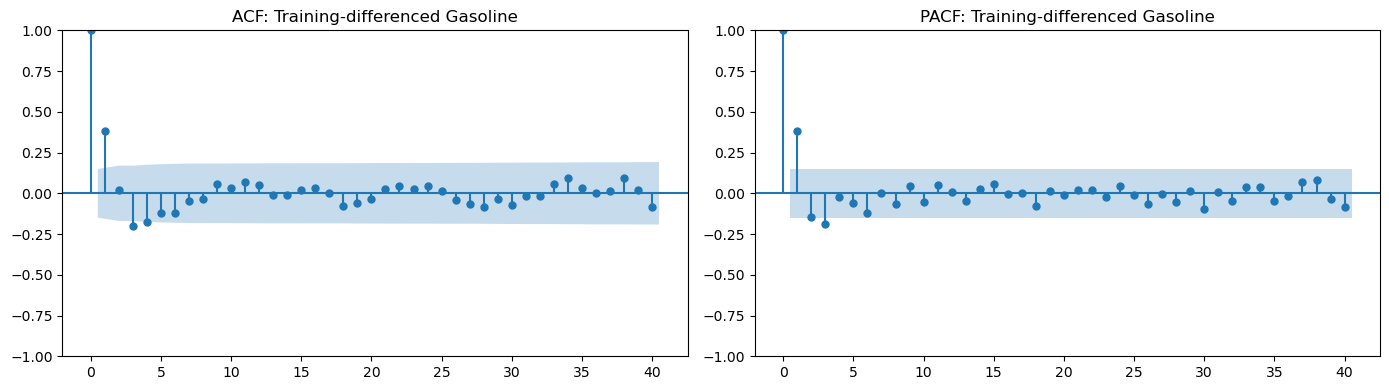

In [ ]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- warnings ---
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ---------------------------------------------------------------------
# DEFINITIONS (train split, Yeo–Johnson transformed, then 1st differences)
# ---------------------------------------------------------------------
# Use the TRAIN portion of the YJ-transformed series
gas_yj_train = yj_df['Gasoline (Euro95) - Average price (F)_yj'].iloc[:train_end_yj].to_numpy(dtype=float)
y_yj_train   = yj_df['Total vehicles sold (Target)_yj'].iloc[:train_end_yj].to_numpy(dtype=float)

# Difference ONCE outside the model (because we'll set d=0, D=0)
exog_gas = gas_yj_train # np.diff(gas_yj_train)      # exogenous on same differenced scale as y
y       = y_yj_train # = np.diff(y_yj_train)         # this is your target_diff equivalent

# ---------------------------------------------------------------------
# 1) Build a fixed window so all models are compared on the SAME rows
# ---------------------------------------------------------------------
max_lag = 6               
start   = max_lag            # drop first max_lag obs from BOTH once
y_fix   = y[start:].copy()
exog0   = exog_gas[start:].copy()

def aicc(llf, nobs, k_params):
    aic = -2*llf + 2*k_params
    return aic + (2*k_params*(k_params+1)) / max(nobs - k_params - 1, 1)

# ---------------------------------------------------------------------
# 2) Search lags on that fixed window
# ---------------------------------------------------------------------
results = []
for L in range(0, max_lag + 1):
    xL = np.roll(exog0, L)
    xL[:L] = np.nan
    mask = ~np.isnan(xL)

    model = SARIMAX(
        y_fix[mask],
        order=(1, 1, 1),
        seasonal_order=(1, 0, 0, 12),   # <- if your best seasonal is (0,0,1,12), change here
        exog=xL[mask].reshape(-1, 1),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    res = model.fit(disp=False)

    results.append({
        "lag":  L,
        "AIC":  res.aic,
        "BIC":  res.bic,
        "AICc": aicc(res.llf, res.nobs, res.params.size)
    })

# ---------------------------------------------------------------------
# 3) Report best lags (same-sample AIC/BIC/AICc)
# ---------------------------------------------------------------------
results_sorted_aic  = sorted(results, key=lambda d: d["AIC"])
results_sorted_bic  = sorted(results, key=lambda d: d["BIC"])
results_sorted_aicc = sorted(results, key=lambda d: d["AICc"])

print("Optimal lags (same sample):")
print("\nBy AIC:")
for r in results_sorted_aic[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nBy BIC:")
for r in results_sorted_bic[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

print("\nBy AICc:")
for r in results_sorted_aicc[:10]:
    print(f"  lag={r['lag']:>2}  AIC={r['AIC']:.2f}  BIC={r['BIC']:.2f}  AICc={r['AICc']:.2f}")

    # Print summary of best lag for each metric
    best_aic  = results_sorted_aic[0]
    best_bic  = results_sorted_bic[0]
    best_aicc = results_sorted_aicc[0]

    print("\nSummary of best lag for each metric:")
    print(f"  Best AIC : lag={best_aic['lag']}  AIC={best_aic['AIC']:.2f}  BIC={best_aic['BIC']:.2f}  AICc={best_aic['AICc']:.2f}")
    print(f"  Best BIC : lag={best_bic['lag']}  AIC={best_bic['AIC']:.2f}  BIC={best_bic['BIC']:.2f}  AICc={best_bic['AICc']:.2f}")
    print(f"  Best AICc: lag={best_aicc['lag']}  AIC={best_aicc['AIC']:.2f}  BIC={best_aicc['BIC']:.2f}  AICc={best_aicc['AICc']:.2f}")

# ---------------------------------------------------------------------
# OPTIONAL diagnostics (on train-differenced exog; just for reference)
# ---------------------------------------------------------------------
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plot_acf(exog_gas, ax=plt.gca(), lags=40)
plt.title('ACF: Training-differenced Gasoline')

plt.subplot(1, 2, 2)
plot_pacf(exog_gas, ax=plt.gca(), lags=40, method='ywm')
plt.title('PACF: Training-differenced Gasoline')

plt.tight_layout()
plt.show()


In [ ]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings("ignore")

# --- Settings ---
horizon = 3
lags_to_test = [3, 5, 6]

# --- Data ---
train_yj = y_train_yj.values
val_yj   = y_val_yj.values
gas_yj_full = yj_df['Gasoline (Euro95) - Average price (F)_yj'].values
n_train = len(train_yj)
n_val = len(val_yj)
lam = yeojohnson_lambdas_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_yeojohnson(z, lam):
    if lam == 0:
        return np.exp(z)
    elif lam == 2:
        return -np.exp(-z)
    out = np.zeros_like(z)
    pos = z >= 0
    out[pos]    = np.power(z[pos] * lam + 1, 1/lam) - 1
    out[~pos]   = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1/(2 - lam))
    return out

results = []

for lag in lags_to_test:
    preds_level = []
    ci80_lower = []
    ci80_upper = []
    ci95_lower = []
    ci95_upper = []

    for t in range(n_val - horizon + 1):
        y_hist = np.concatenate([train_yj, val_yj[:t]])
        idx_offset = n_train + t

        gas_hist = np.concatenate([gas_yj_full[:n_train], gas_yj_full[n_train:n_train+t]])
        exog_lag = make_lag(gas_hist, lag)
        exog_hist = exog_lag.reshape(-1, 1)

        valid = ~np.isnan(exog_hist).flatten()
        y_hist_valid = y_hist[valid]
        exog_hist_valid = exog_hist[valid]

        gas_future = gas_yj_full[:idx_offset + horizon]
        exog_future_lag = make_lag(gas_future, lag)[-horizon:].reshape(-1, 1)

        model = SARIMAX(
            y_hist_valid,
            exog=exog_hist_valid,
            order=(1, 1, 1),
            seasonal_order=(1, 0, 0, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False)

        fc = res.get_forecast(steps=horizon, exog=exog_future_lag)
        yj_forecast_level = fc.predicted_mean[-1]

        preds_level.append(inv_yeojohnson(np.array([yj_forecast_level]), lam)[0])

        ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
        ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
        ci80_lower.append(inv_yeojohnson(np.array([ci80]), lam)[0])
        ci80_upper.append(inv_yeojohnson(np.array([ci80_u]), lam)[0])
        ci95_lower.append(inv_yeojohnson(np.array([ci95]), lam)[0])
        ci95_upper.append(inv_yeojohnson(np.array([ci95_u]), lam)[0])

    actuals_level = inv_yeojohnson(val_yj[horizon-1:], lam)
    rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
    mape = mean_absolute_percentage_error(actuals_level, preds_level)
    results.append({'lag': lag, 'rmse': rmse, 'mape': mape})

    # Plot for each lag
    dates = df["Time Period (T)"].iloc[train_end_yj + horizon - 1 : val_end_yj][:len(preds_level)]
    plt.figure(figsize=(12, 5))
    plt.plot(dates, actuals_level, marker='o', color='black', label='Actual')
    plt.plot(dates, preds_level, marker='x', color='blue', label=f'Forecast (lag {lag})')
    plt.fill_between(dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
    plt.fill_between(dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
    plt.title(f'SARIMAX(1,1,1)(1,0,0,12) + Gasoline lag {lag}: Rolling 3-step Forecasts')
    plt.xlabel('Date')
    plt.ylabel(target_raw)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Lag {lag}: Validation RMSE (rolling): {rmse:.2f}")
    print(f"Lag {lag}: Validation MAPE (rolling): {mape:.2%}")

# Print summary
print("\nSummary of RMSE and MAPE for each lag:")
for r in results:
    print(f"Lag {r['lag']}: RMSE={r['rmse']:.2f}, MAPE={r['mape']:.2%}")

### Fit Sarimax and diagnose 

> voeg evt rmse van og model om beter te vergelijken, en verwijder de plots

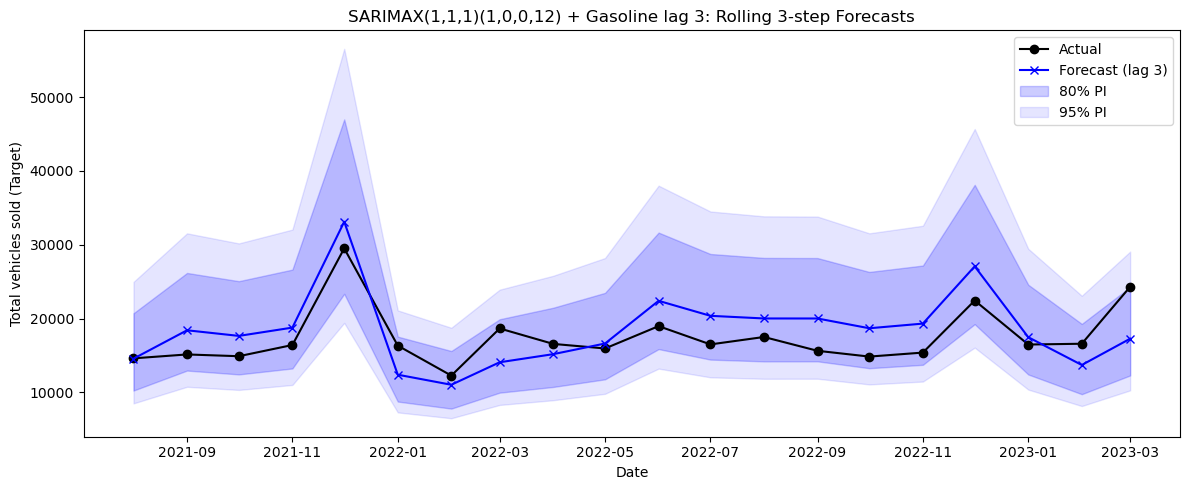

Lag 3: Validation RMSE (rolling): 3462.90
Lag 3: Validation MAPE (rolling): 17.32%


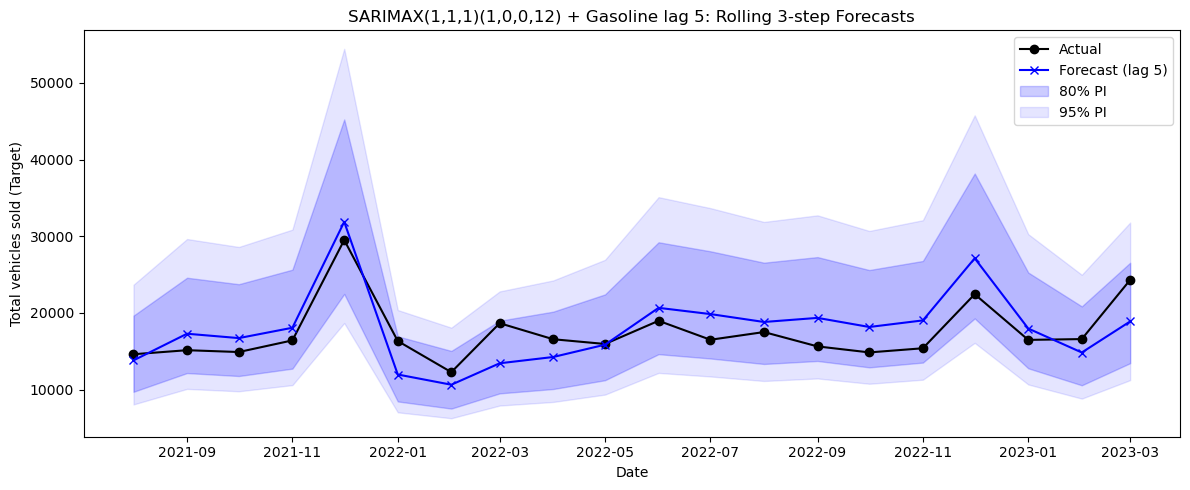

Lag 5: Validation RMSE (rolling): 3013.87
Lag 5: Validation MAPE (rolling): 15.08%


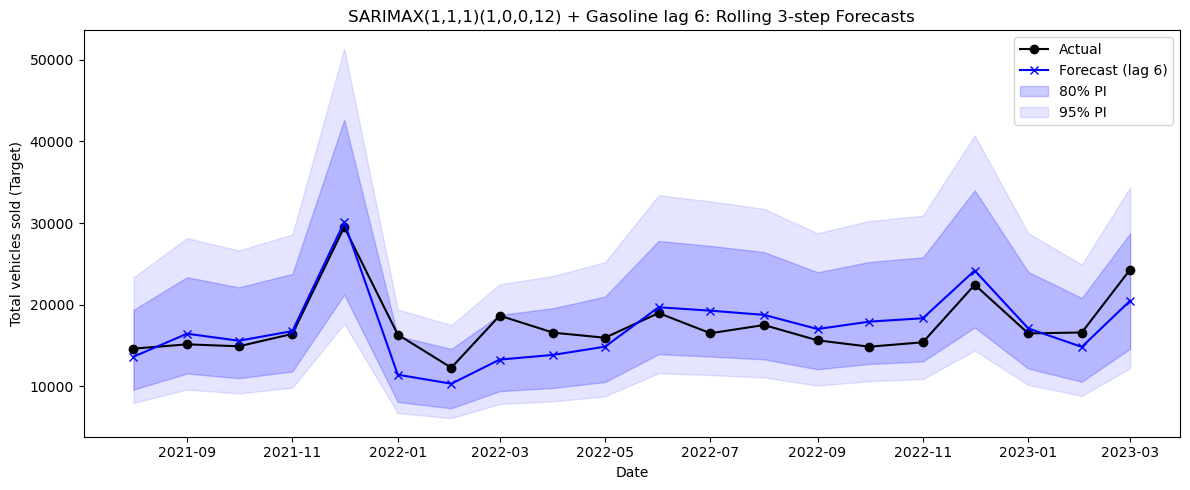

Lag 6: Validation RMSE (rolling): 2450.25
Lag 6: Validation MAPE (rolling): 11.81%

Summary of RMSE and MAPE for each lag:
Lag 3: RMSE=3462.90, MAPE=17.32%
Lag 5: RMSE=3013.87, MAPE=15.08%
Lag 6: RMSE=2450.25, MAPE=11.81%


In [19]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings("ignore")

# --- Settings ---
horizon = 3
lags_to_test = [3, 5, 6]

# --- Data ---
train_yj = y_train_yj.values
val_yj   = y_val_yj.values
gas_yj_full = yj_df['Gasoline (Euro95) - Average price (F)_yj'].values
n_train = len(train_yj)
n_val = len(val_yj)
lam = yeojohnson_lambdas_all[target_raw]

def make_lag(arr, lag):
    out = np.roll(arr, lag)
    out[:lag] = np.nan
    return out

def inv_yeojohnson(z, lam):
    if lam == 0:
        return np.exp(z)
    elif lam == 2:
        return -np.exp(-z)
    out = np.zeros_like(z)
    pos = z >= 0
    out[pos]    = np.power(z[pos] * lam + 1, 1/lam) - 1
    out[~pos]   = 1 - np.power(-(z[~pos]) * (2 - lam) + 1, 1/(2 - lam))
    return out

results = []

for lag in lags_to_test:
    preds_level = []
    ci80_lower = []
    ci80_upper = []
    ci95_lower = []
    ci95_upper = []

    for t in range(n_val - horizon + 1):
        y_hist = np.concatenate([train_yj, val_yj[:t]])
        idx_offset = n_train + t

        gas_hist = np.concatenate([gas_yj_full[:n_train], gas_yj_full[n_train:n_train+t]])
        exog_lag = make_lag(gas_hist, lag)
        exog_hist = exog_lag.reshape(-1, 1)

        valid = ~np.isnan(exog_hist).flatten()
        y_hist_valid = y_hist[valid]
        exog_hist_valid = exog_hist[valid]

        gas_future = gas_yj_full[:idx_offset + horizon]
        exog_future_lag = make_lag(gas_future, lag)[-horizon:].reshape(-1, 1)

        model = SARIMAX(
            y_hist_valid,
            exog=exog_hist_valid,
            order=(1, 1, 1),
            seasonal_order=(1, 0, 0, 12),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False)

        fc = res.get_forecast(steps=horizon, exog=exog_future_lag)
        yj_forecast_level = fc.predicted_mean[-1]

        preds_level.append(inv_yeojohnson(np.array([yj_forecast_level]), lam)[0])

        ci80, ci80_u = fc.conf_int(alpha=0.20)[-1]
        ci95, ci95_u = fc.conf_int(alpha=0.05)[-1]
        ci80_lower.append(inv_yeojohnson(np.array([ci80]), lam)[0])
        ci80_upper.append(inv_yeojohnson(np.array([ci80_u]), lam)[0])
        ci95_lower.append(inv_yeojohnson(np.array([ci95]), lam)[0])
        ci95_upper.append(inv_yeojohnson(np.array([ci95_u]), lam)[0])

    actuals_level = inv_yeojohnson(val_yj[horizon-1:], lam)
    rmse = np.sqrt(mean_squared_error(actuals_level, preds_level))
    mape = mean_absolute_percentage_error(actuals_level, preds_level)
    results.append({'lag': lag, 'rmse': rmse, 'mape': mape})

    # Plot for each lag
    dates = df["Time Period (T)"].iloc[train_end_yj + horizon - 1 : val_end_yj][:len(preds_level)]
    plt.figure(figsize=(12, 5))
    plt.plot(dates, actuals_level, marker='o', color='black', label='Actual')
    plt.plot(dates, preds_level, marker='x', color='blue', label=f'Forecast (lag {lag})')
    plt.fill_between(dates, ci80_lower, ci80_upper, color='blue', alpha=0.2, label='80% PI')
    plt.fill_between(dates, ci95_lower, ci95_upper, color='blue', alpha=0.1, label='95% PI')
    plt.title(f'SARIMAX(1,1,1)(1,0,0,12) + Gasoline lag {lag}: Rolling 3-step Forecasts')
    plt.xlabel('Date')
    plt.ylabel(target_raw)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Lag {lag}: Validation RMSE (rolling): {rmse:.2f}")
    print(f"Lag {lag}: Validation MAPE (rolling): {mape:.2%}")

# Print summary
print("\nSummary of RMSE and MAPE for each lag:")
for r in results:
    print(f"Lag {r['lag']}: RMSE={r['rmse']:.2f}, MAPE={r['mape']:.2%}")

## 7b Company car tax rate (%)

### Lag Selection

### Fit Sarimax and diagnose 

## 7c Google Home Charging

### Lag Selection

### Fit Sarimax and diagnose 

## 7d Consumer confidence (E)

### Lag Selection

### Fit Sarimax and diagnose 

# 8 All features together/ turn this into top features together

| Model                       | Lag | RMSE        | MAPE       |
| --------------------------- | --- | ----------- | ---------- |
| **Baseline (no exogenous)** | –   | 4359.91     | 18.31%     |
| Gasoline price              | 6   | 3797.68     | **15.54%** |
| Company car tax rate (%)    | 3   | 3756.22     | 19.13%     |
| Home charging (G)           | 5   | **3708.38** | 18.40%     |
| Consumer confidence (E)     | 6   | 3801.21     | 18.87%     |


**Interpretation**
- Gasoline price (lag 6) delivers the strongest MAPE improvement, dropping MAPE from 18.31% to 15.54%.

- Home charging (lag 5) yields the largest RMSE drop, shaving almost 650 units off the baseline error.

- Company car tax and consumer confidence both improve RMSE but worsen MAPE, suggesting they may reduce large errors but introduce relative bias.

Feature Combinations
- Option 1: Gasoline + Home Charging
    Captures both economic and behavioral signals from two uncorrelated sources. This is likely the most complementary and effective two-feature combination.

- Option 2: Gasoline + Company Car Tax
    Combines economic cost and policy incentives. This pair balances market behavior and government regulation.

- Optional third variable: Consumer Confidence
    This can be considered if residual diagnostics remain acceptable (no strong multicollinearity or autocorrelation). It captures macroeconomic perception but may be noisier.

**Next Steps**
- Test the performance of each combination using 3-step rolling validation.

- Check residuals (ACF, PACF, Ljung-Box test) to confirm no model misspecification.

- Evaluate combined models on both RMSE and MAPE.

- Select the final model based on predictive accuracy and diagnostic performance.

### Option 1 Gasoline + Home Charging

Validation RMSE (3-step rolling): 4582.25
Validation MAPE (3-step rolling): 17.73%


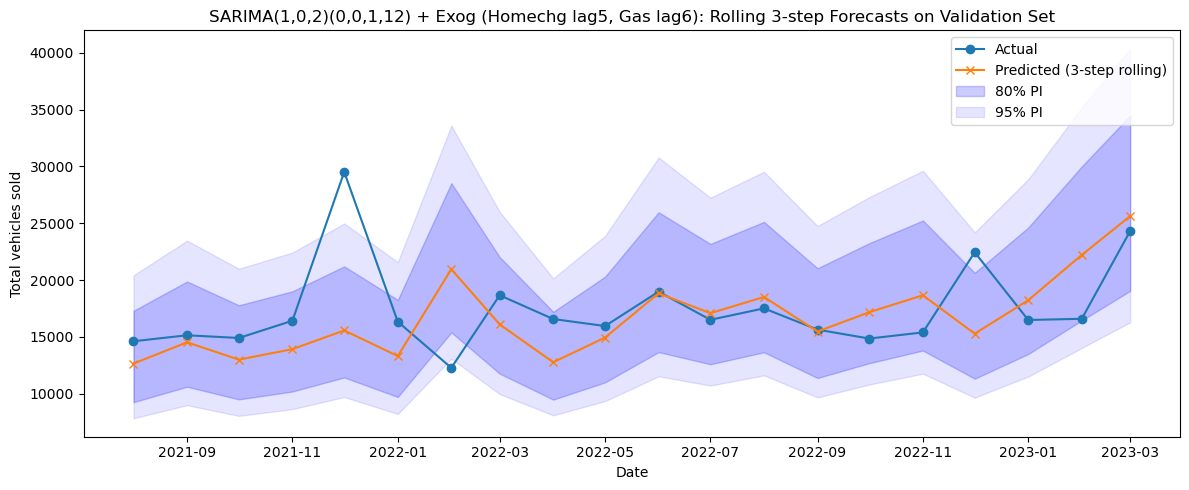

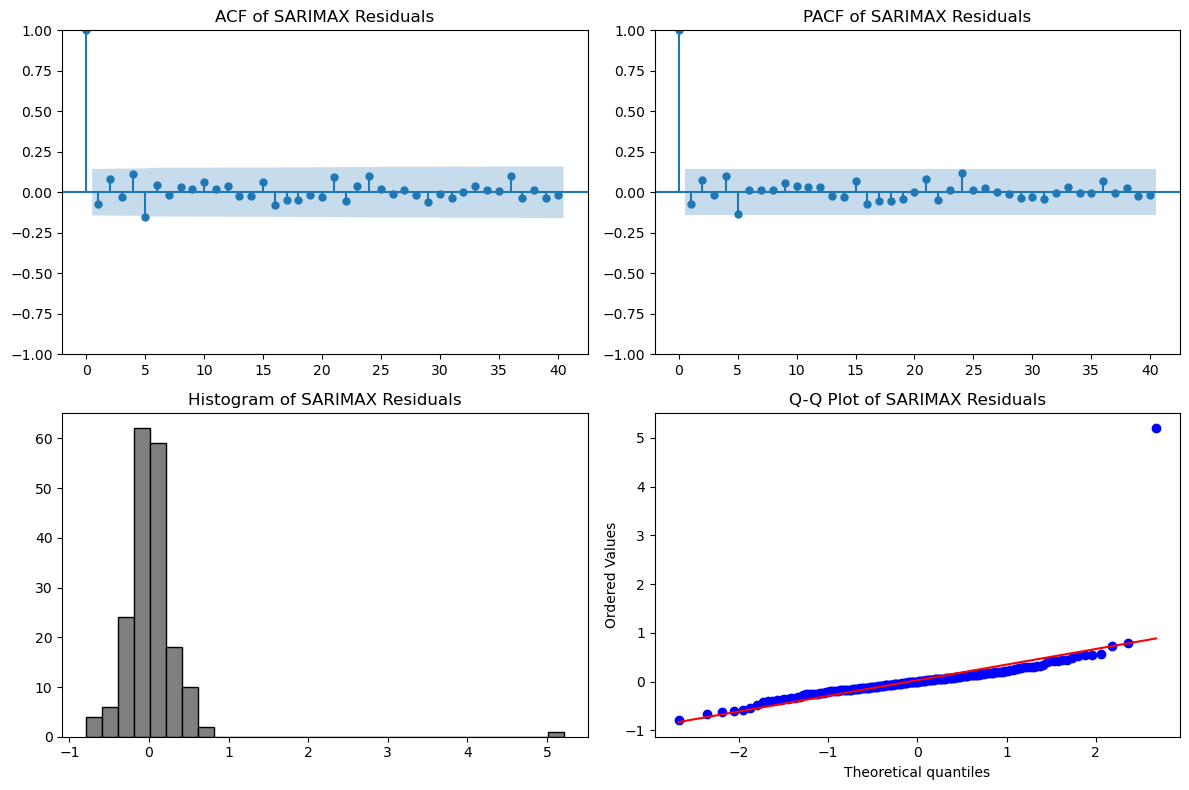

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10  10.828920   0.371001
20  14.647518   0.796209
30  20.558511   0.901184


In [ ]:
# ─── 1. Prepare data ───────────────────────────────────────────────────────────
homechg_bc = boxcox_all['Home charging (G)']
gas_bc     = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc  = boxcox_all[target]

history_y        = list(target_bc[:train_end])
history_homechg  = list(homechg_bc[:train_end])
history_gas      = list(gas_bc[:train_end])

val_y        = target_bc[train_end:val_end]
val_homechg  = homechg_bc[train_end:val_end]
val_gas      = gas_bc[train_end:val_end]

horizon = 3
lags    = [5, 6]  # lags for homechg, gas

predictions_bc = []
conf_int_80    = []
conf_int_95    = []

# ─── 2. Rolling loop ────────────────────────────────────────────────────────────
for t in range(len(val_y) - horizon + 1):
    # Lag exogenous variables
    homechg_hist = np.array(history_homechg)
    gas_hist     = np.array(history_gas)

    homechg_hist_lag5 = np.roll(homechg_hist, lags[0]); homechg_hist_lag5[:lags[0]] = np.nan
    gas_hist_lag6     = np.roll(gas_hist, lags[1]); gas_hist_lag6[:lags[1]] = np.nan

    # Align all (drop first 6 for max lag)
    y_hist = np.array(history_y)[lags[1]:]
    exog_hist = np.column_stack([
        homechg_hist_lag5[lags[1]:], gas_hist_lag6[lags[1]:]
    ])

    # Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    # Recursive 3-step forecast with intervals
    temp_history_y        = history_y.copy()
    temp_history_homechg  = history_homechg.copy()
    temp_history_gas      = history_gas.copy()
    for step in range(horizon):
        idx = t + step
        homechg_exog_full = np.concatenate([np.array(temp_history_homechg)[-lags[0]:], [val_homechg[idx]]])
        gas_exog_full     = np.concatenate([np.array(temp_history_gas)[-lags[1]:], [val_gas[idx]]])
        homechg_exog_lag5 = np.roll(homechg_exog_full, lags[0])[lags[0]:]
        gas_exog_lag6     = np.roll(gas_exog_full, lags[1])[lags[1]:]
        exog_next = np.column_stack([
            homechg_exog_lag5, gas_exog_lag6
        ])
        res = fitted.get_forecast(steps=1, exog=exog_next)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history_y.append(yhat)
        temp_history_homechg.append(val_homechg[idx])
        temp_history_gas.append(val_gas[idx])
    predictions_bc.append(yhat)
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update rolling history with actuals for next window
    history_y.append(val_y[t])
    history_homechg.append(val_homechg[t])
    history_gas.append(val_gas[t])

# ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig  = inv_boxcox(pred_bc, lam) - shift
actuals    = y_val.values[horizon-1:]

conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

rmse_rolling = np.sqrt(mean_squared_error(actuals, pred_orig))
mape_rolling = mean_absolute_percentage_error(actuals, pred_orig)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

# ─── 4. Plot results ────────────────────────────────────────────────────────────
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]
plt.figure(figsize=(12, 5))
plt.plot(x_dates, actuals, label='Actual', marker='o')
plt.plot(x_dates, pred_orig, label='Predicted (3-step rolling)', marker='x')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(1,0,2)(0,0,1,12) + Exog (Homechg lag5, Gas lag6): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# ─── 5. Residual diagnostics ────────────────────────────────────────────────────
import scipy.stats as stats

# Get residuals from the last fitted SARIMAX model in the rolling loop
residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF plot
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

# PACF plot
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

# Histogram
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation (white noise)
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
print(lb_test[['lb_stat', 'lb_pvalue']])

### Option 2 Gasoline + Company Car Tax

Validation RMSE (3-step rolling): 4721.88
Validation MAPE (3-step rolling): 18.73%


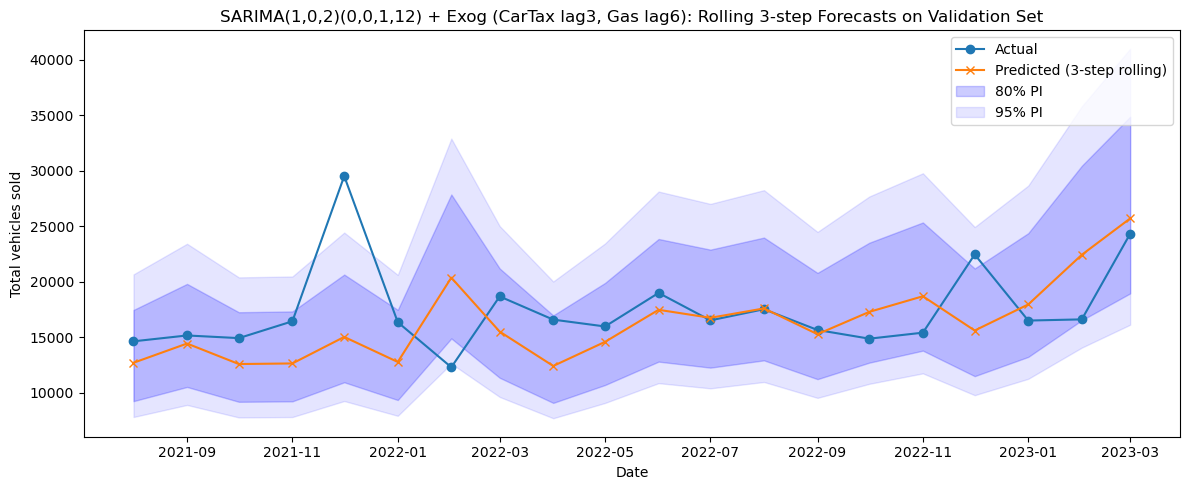

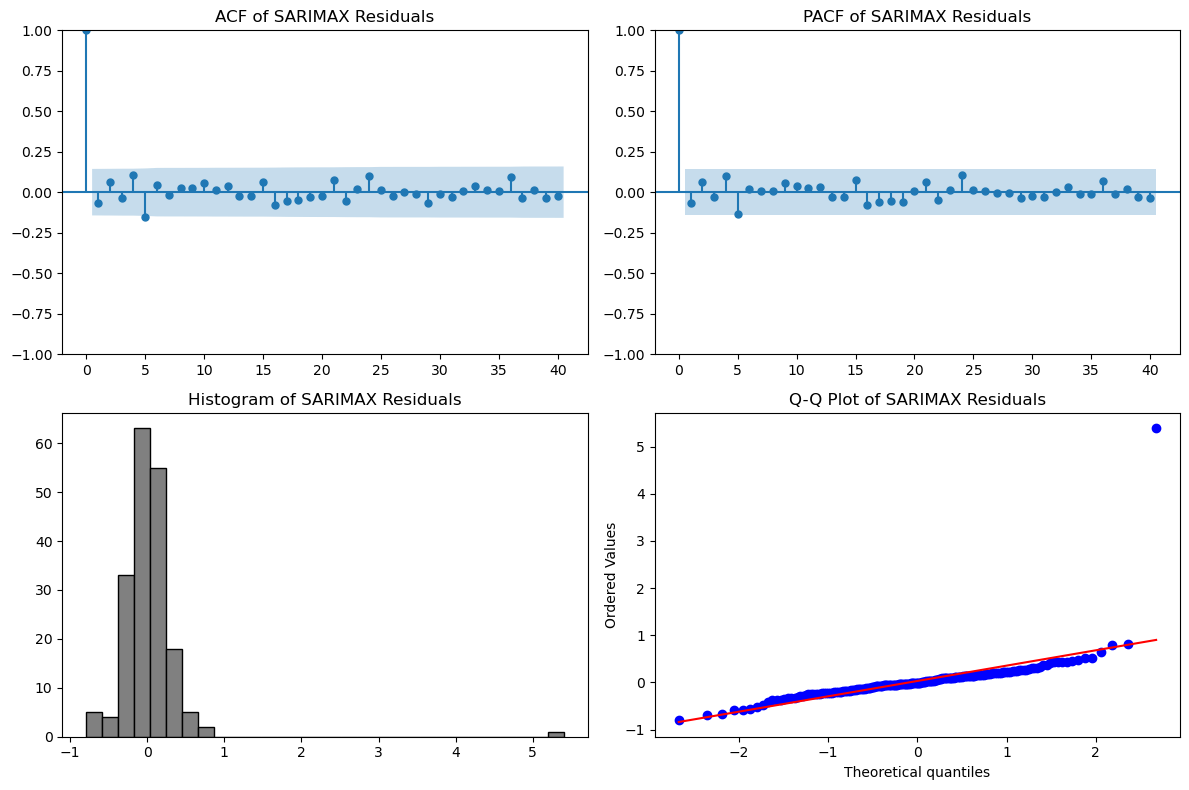

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10   9.819138   0.456502
20  14.042439   0.828338
30  19.337241   0.932663


In [ ]:
# ─── 1. Prepare data ───────────────────────────────────────────────────────────
car_tax_bc = boxcox_all['Company car tax rate (%)']
gas_bc     = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc  = boxcox_all[target]

history_y      = list(target_bc[:train_end])
history_tax    = list(car_tax_bc[:train_end])
history_gas    = list(gas_bc[:train_end])

val_y      = target_bc[train_end:val_end]
val_tax    = car_tax_bc[train_end:val_end]
val_gas    = gas_bc[train_end:val_end]

horizon = 3
lags    = [3, 6]  # lags for car tax, gas

predictions_bc = []
conf_int_80    = []
conf_int_95    = []

# ─── 2. Rolling loop ────────────────────────────────────────────────────────────
for t in range(len(val_y) - horizon + 1):
    # Lag exogenous variables
    tax_hist = np.array(history_tax)
    gas_hist = np.array(history_gas)

    tax_hist_lag3 = np.roll(tax_hist, lags[0]); tax_hist_lag3[:lags[0]] = np.nan
    gas_hist_lag6 = np.roll(gas_hist, lags[1]); gas_hist_lag6[:lags[1]] = np.nan

    # Align all (drop first 6 for max lag)
    y_hist = np.array(history_y)[lags[1]:]
    exog_hist = np.column_stack([
        tax_hist_lag3[lags[1]:], gas_hist_lag6[lags[1]:]
    ])

    # Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    # Recursive 3-step forecast with intervals
    temp_history_y      = history_y.copy()
    temp_history_tax    = history_tax.copy()
    temp_history_gas    = history_gas.copy()
    for step in range(horizon):
        idx = t + step
        tax_exog_full = np.concatenate([np.array(temp_history_tax)[-lags[0]:], [val_tax[idx]]])
        gas_exog_full = np.concatenate([np.array(temp_history_gas)[-lags[1]:], [val_gas[idx]]])
        tax_exog_lag3 = np.roll(tax_exog_full, lags[0])[lags[0]:]
        gas_exog_lag6 = np.roll(gas_exog_full, lags[1])[lags[1]:]
        exog_next = np.column_stack([
            tax_exog_lag3, gas_exog_lag6
        ])
        res = fitted.get_forecast(steps=1, exog=exog_next)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history_y.append(yhat)
        temp_history_tax.append(val_tax[idx])
        temp_history_gas.append(val_gas[idx])
    predictions_bc.append(yhat)
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update rolling history with actuals for next window
    history_y.append(val_y[t])
    history_tax.append(val_tax[t])
    history_gas.append(val_gas[t])

# ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig  = inv_boxcox(pred_bc, lam) - shift
actuals    = y_val.values[horizon-1:]

conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

rmse_rolling = np.sqrt(mean_squared_error(actuals, pred_orig))
mape_rolling = mean_absolute_percentage_error(actuals, pred_orig)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

# ─── 4. Plot results ────────────────────────────────────────────────────────────
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]
plt.figure(figsize=(12, 5))
plt.plot(x_dates, actuals, label='Actual', marker='o')
plt.plot(x_dates, pred_orig, label='Predicted (3-step rolling)', marker='x')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(1,0,2)(0,0,1,12) + Exog (CarTax lag3, Gas lag6): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# ─── 5. Residual diagnostics ────────────────────────────────────────────────────
import scipy.stats as stats

# Get residuals from the last fitted SARIMAX model in the rolling loop
residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF plot
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

# PACF plot
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

# Histogram
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation (white noise)
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
print(lb_test[['lb_stat', 'lb_pvalue']])

### option 3 all features

Validation RMSE (3-step rolling): 4541.29
Validation MAPE (3-step rolling): 16.70%


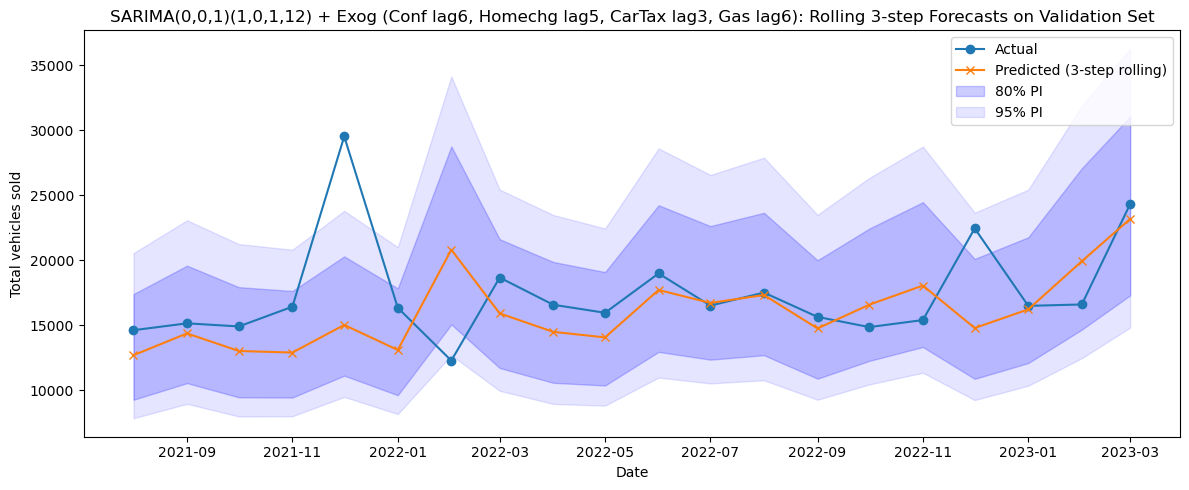

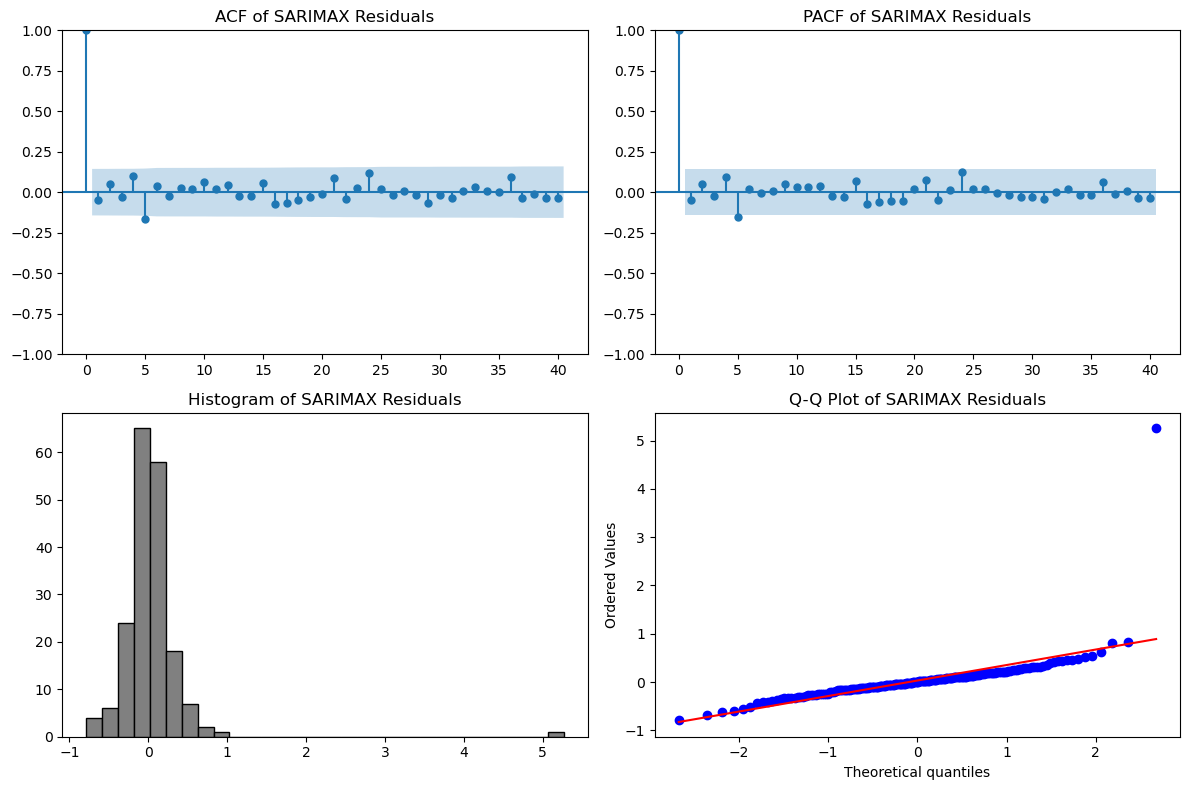

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10   9.615913   0.474811
20  13.649981   0.847790
30  20.076234   0.914541


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ─── 1. Prepare data ───────────────────────────────────────────────────────────
conf_bc    = boxcox_all['Consumer confidence (E)']
homechg_bc = boxcox_all['Home charging (G)']
car_tax_bc = boxcox_all['Company car tax rate (%)']
gas_bc     = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc  = boxcox_all[target]

history_y        = list(target_bc[:train_end])
history_conf     = list(conf_bc[:train_end])
history_homechg  = list(homechg_bc[:train_end])
history_tax      = list(car_tax_bc[:train_end])
history_gas      = list(gas_bc[:train_end])

val_y        = target_bc[train_end:val_end]
val_conf     = conf_bc[train_end:val_end]
val_homechg  = homechg_bc[train_end:val_end]
val_tax      = car_tax_bc[train_end:val_end]
val_gas      = gas_bc[train_end:val_end]

horizon = 3
lags    = [6, 5, 3, 6]  # lags for conf, homechg, tax, gas

predictions_bc = []
conf_int_80    = []
conf_int_95    = []

# ─── 2. Rolling loop ────────────────────────────────────────────────────────────
for t in range(len(val_y) - horizon + 1):
    # Lag all exogenous variables
    conf_hist    = np.array(history_conf)
    homechg_hist = np.array(history_homechg)
    tax_hist     = np.array(history_tax)
    gas_hist     = np.array(history_gas)

    conf_hist_lag6    = np.roll(conf_hist, lags[0]); conf_hist_lag6[:lags[0]] = np.nan
    homechg_hist_lag5 = np.roll(homechg_hist, lags[1]); homechg_hist_lag5[:lags[1]] = np.nan
    tax_hist_lag3     = np.roll(tax_hist, lags[2]); tax_hist_lag3[:lags[2]] = np.nan
    gas_hist_lag6     = np.roll(gas_hist, lags[3]); gas_hist_lag6[:lags[3]] = np.nan

    # Align all (drop first 6)
    y_hist = np.array(history_y)[6:]
    exog_hist = np.column_stack([
        conf_hist_lag6[6:], homechg_hist_lag5[6:], tax_hist_lag3[6:], gas_hist_lag6[6:]
    ])

    # Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    # Recursive 3-step forecast with intervals
    temp_history_y        = history_y.copy()
    temp_history_conf     = history_conf.copy()
    temp_history_homechg  = history_homechg.copy()
    temp_history_tax      = history_tax.copy()
    temp_history_gas      = history_gas.copy()
    for step in range(horizon):
        idx = t + step
        conf_exog_full    = np.concatenate([np.array(temp_history_conf)[-lags[0]:], [val_conf[idx]]])
        homechg_exog_full = np.concatenate([np.array(temp_history_homechg)[-lags[1]:], [val_homechg[idx]]])
        tax_exog_full     = np.concatenate([np.array(temp_history_tax)[-lags[2]:], [val_tax[idx]]])
        gas_exog_full     = np.concatenate([np.array(temp_history_gas)[-lags[3]:], [val_gas[idx]]])
        conf_exog_lag6    = np.roll(conf_exog_full, lags[0])[lags[0]:]
        homechg_exog_lag5 = np.roll(homechg_exog_full, lags[1])[lags[1]:]
        tax_exog_lag3     = np.roll(tax_exog_full, lags[2])[lags[2]:]
        gas_exog_lag6     = np.roll(gas_exog_full, lags[3])[lags[3]:]
        exog_next = np.column_stack([
            conf_exog_lag6, homechg_exog_lag5, tax_exog_lag3, gas_exog_lag6
        ])
        res = fitted.get_forecast(steps=1, exog=exog_next)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history_y.append(yhat)
        temp_history_conf.append(val_conf[idx])
        temp_history_homechg.append(val_homechg[idx])
        temp_history_tax.append(val_tax[idx])
        temp_history_gas.append(val_gas[idx])
    predictions_bc.append(yhat)
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update rolling history with actuals for next window
    history_y.append(val_y[t])
    history_conf.append(val_conf[t])
    history_homechg.append(val_homechg[t])
    history_tax.append(val_tax[t])
    history_gas.append(val_gas[t])

# ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig  = inv_boxcox(pred_bc, lam) - shift
actuals    = y_val.values[horizon-1:]

conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

rmse_rolling = np.sqrt(mean_squared_error(actuals, pred_orig))
mape_rolling = mean_absolute_percentage_error(actuals, pred_orig)
print(f"Validation RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Validation MAPE (3-step rolling): {mape_rolling:.2%}")

# ─── 4. Plot results ────────────────────────────────────────────────────────────
x_dates = df["Time Period (T)"][train_end+horizon-1:val_end]
plt.figure(figsize=(12, 5))
plt.plot(x_dates, actuals, label='Actual', marker='o')
plt.plot(x_dates, pred_orig, label='Predicted (3-step rolling)', marker='x')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(0,0,1)(1,0,1,12) + Exog (Conf lag6, Homechg lag5, CarTax lag3, Gas lag6): Rolling 3-step Forecasts on Validation Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# ─── 5. Residual diagnostics ────────────────────────────────────────────────────
import scipy.stats as stats

# Get residuals from the last fitted SARIMAX model in the rolling loop
residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF plot
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

# PACF plot
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

# Histogram
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation (white noise)
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
print(lb_test[['lb_stat', 'lb_pvalue']])

# 6 Plot/evaluate with target value

### Gas oline + Home Charging on test 

Test RMSE (3-step rolling): 4645.30
Test MAPE (3-step rolling): 13.06%


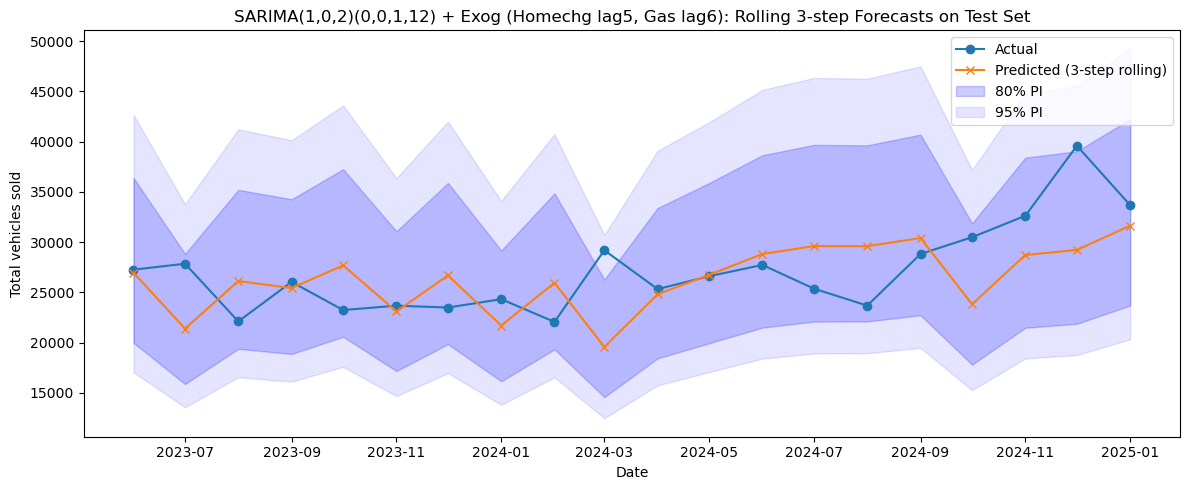

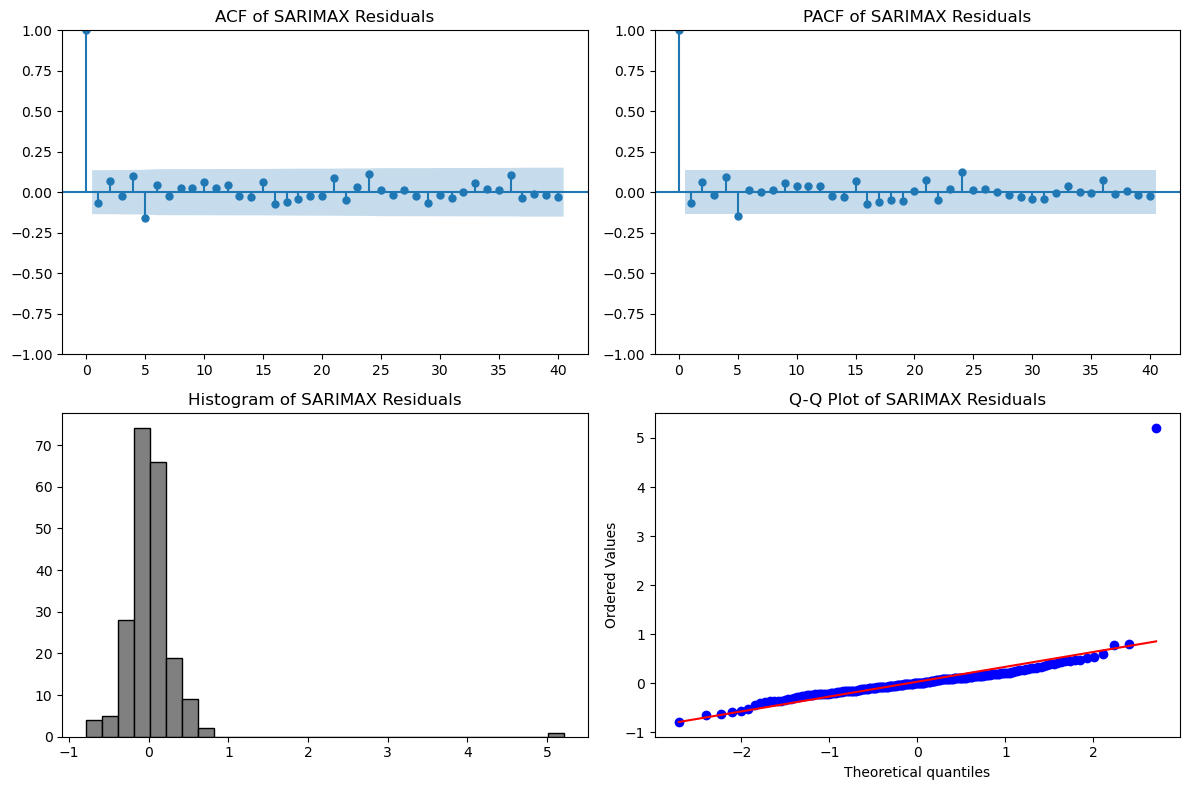

Ljung-Box test p-values (no autocorrelation if > 0.05):


In [ ]:
# --- Evaluate SARIMAX (Homechg lag5, Gas lag6) on TEST SET ---

homechg_bc = boxcox_all['Home charging (G)']
gas_bc     = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc  = boxcox_all[target]

# Use all data up to end of validation as history, test as hold-out
history_y        = list(target_bc[:val_end])
history_homechg  = list(homechg_bc[:val_end])
history_gas      = list(gas_bc[:val_end])

test_y        = target_bc[val_end:]
test_homechg  = homechg_bc[val_end:]
test_gas      = gas_bc[val_end:]

horizon = 3
lags    = [5, 6]  # lags for homechg, gas

predictions_bc = []
conf_int_80    = []
conf_int_95    = []

for t in range(len(test_y) - horizon + 1):
    # Lag exogenous variables
    homechg_hist = np.array(history_homechg)
    gas_hist     = np.array(history_gas)

    homechg_hist_lag5 = np.roll(homechg_hist, lags[0]); homechg_hist_lag5[:lags[0]] = np.nan
    gas_hist_lag6     = np.roll(gas_hist, lags[1]); gas_hist_lag6[:lags[1]] = np.nan

    # Align all (drop first 6 for max lag)
    y_hist = np.array(history_y)[lags[1]:]
    exog_hist = np.column_stack([
        homechg_hist_lag5[lags[1]:], gas_hist_lag6[lags[1]:]
    ])

    # Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    # Recursive 3-step forecast with intervals
    temp_history_y        = history_y.copy()
    temp_history_homechg  = history_homechg.copy()
    temp_history_gas      = history_gas.copy()
    for step in range(horizon):
        idx = t + step
        homechg_exog_full = np.concatenate([np.array(temp_history_homechg)[-lags[0]:], [test_homechg[idx]]])
        gas_exog_full     = np.concatenate([np.array(temp_history_gas)[-lags[1]:], [test_gas[idx]]])
        homechg_exog_lag5 = np.roll(homechg_exog_full, lags[0])[lags[0]:]
        gas_exog_lag6     = np.roll(gas_exog_full, lags[1])[lags[1]:]
        exog_next = np.column_stack([
            homechg_exog_lag5, gas_exog_lag6
        ])
        res = fitted.get_forecast(steps=1, exog=exog_next)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history_y.append(yhat)
        temp_history_homechg.append(test_homechg[idx])
        temp_history_gas.append(test_gas[idx])
    predictions_bc.append(yhat)
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update rolling history with actuals for next window
    history_y.append(test_y[t])
    history_homechg.append(test_homechg[t])
    history_gas.append(test_gas[t])

# --- Invert Box–Cox & compute metrics ---
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig  = inv_boxcox(pred_bc, lam) - shift
actuals    = y_test.values[horizon-1:]

conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

rmse_rolling = np.sqrt(mean_squared_error(actuals, pred_orig))
mape_rolling = mean_absolute_percentage_error(actuals, pred_orig)
print(f"Test RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Test MAPE (3-step rolling): {mape_rolling:.2%}")

# --- Plot results ---
x_dates = df["Time Period (T)"][val_end+horizon-1:]
plt.figure(figsize=(12, 5))
plt.plot(x_dates, actuals, label='Actual', marker='o')
plt.plot(x_dates, pred_orig, label='Predicted (3-step rolling)', marker='x')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(1,0,2)(0,0,1,12) + Exog (Homechg lag5, Gas lag6): Rolling 3-step Forecasts on Test Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# --- Residual diagnostics ---
import scipy.stats as stats

residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")
plt.tight_layout()
plt.show()

lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")

### Cartax and gas on test

Test RMSE (3-step rolling): 4618.95
Test MAPE (3-step rolling): 12.58%


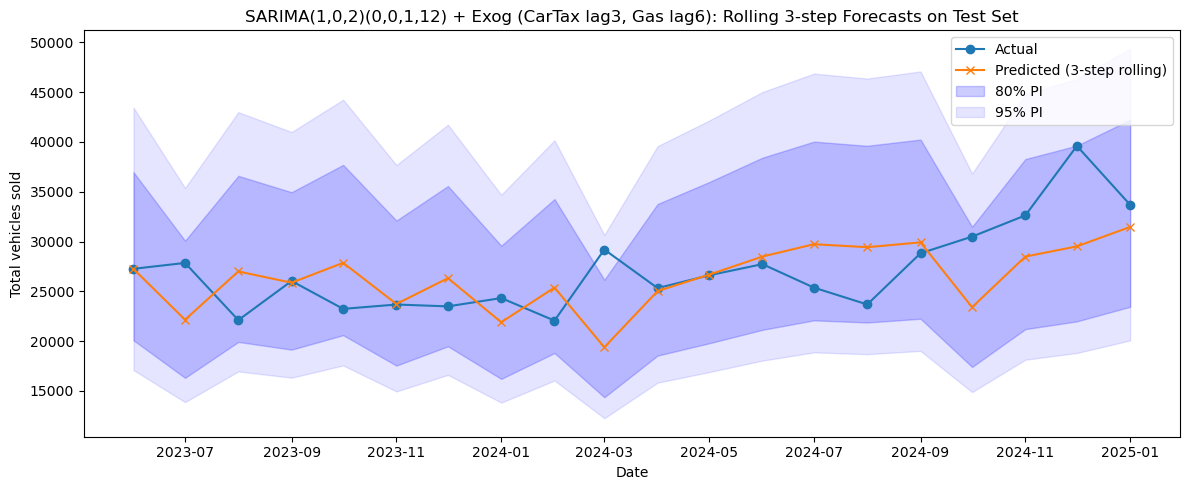

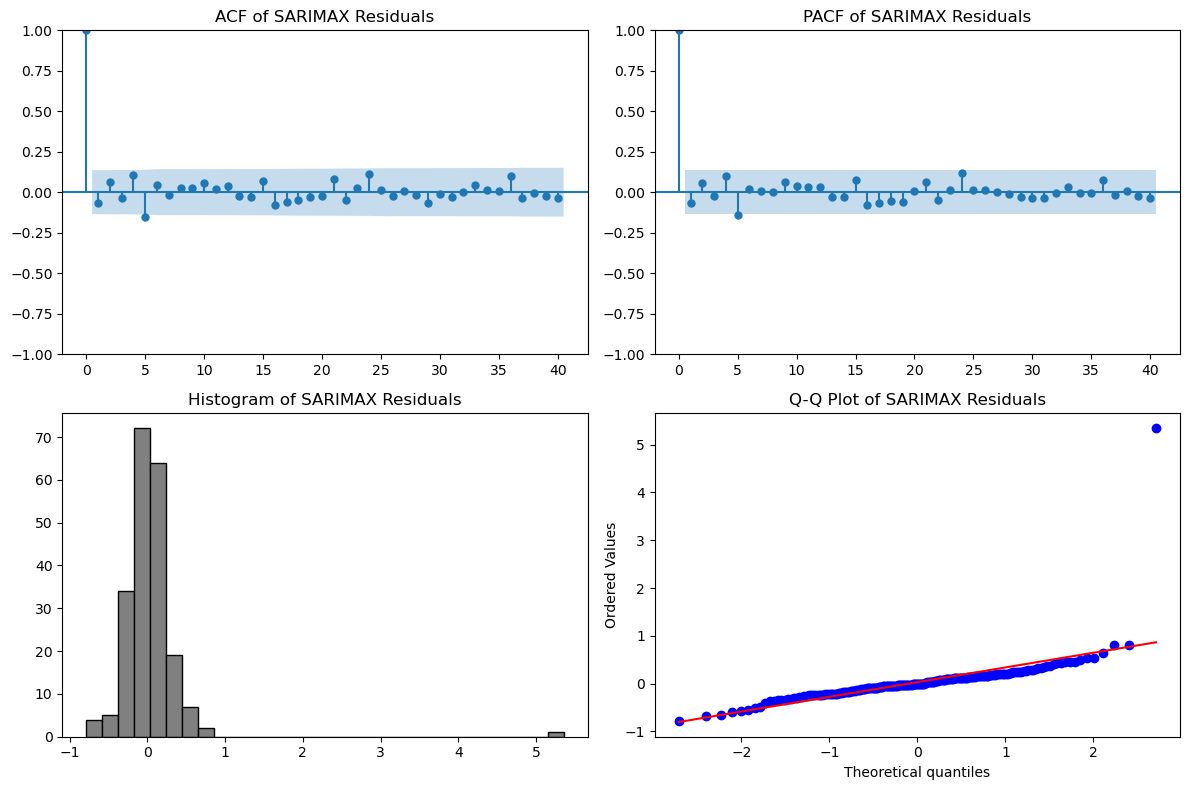

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10  11.026582   0.355451
20  16.017983   0.715508
30  22.312504   0.842436


In [ ]:
# --- Evaluate SARIMAX (CarTax lag3, Gas lag6) on TEST SET ---

car_tax_bc = boxcox_all['Company car tax rate (%)']
gas_bc     = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc  = boxcox_all[target]

# Use all data up to end of validation as history, test as hold-out
history_y      = list(target_bc[:val_end])
history_tax    = list(car_tax_bc[:val_end])
history_gas    = list(gas_bc[:val_end])

test_y      = target_bc[val_end:]
test_tax    = car_tax_bc[val_end:]
test_gas    = gas_bc[val_end:]

horizon = 3
lags    = [3, 6]  # lags for car tax, gas

predictions_bc = []
conf_int_80    = []
conf_int_95    = []

for t in range(len(test_y) - horizon + 1):
    # Lag exogenous variables
    tax_hist = np.array(history_tax)
    gas_hist = np.array(history_gas)

    tax_hist_lag3 = np.roll(tax_hist, lags[0]); tax_hist_lag3[:lags[0]] = np.nan
    gas_hist_lag6 = np.roll(gas_hist, lags[1]); gas_hist_lag6[:lags[1]] = np.nan

    # Align all (drop first 6 for max lag)
    y_hist = np.array(history_y)[lags[1]:]
    exog_hist = np.column_stack([
        tax_hist_lag3[lags[1]:], gas_hist_lag6[lags[1]:]
    ])

    # Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    # Recursive 3-step forecast with intervals
    temp_history_y      = history_y.copy()
    temp_history_tax    = history_tax.copy()
    temp_history_gas    = history_gas.copy()
    for step in range(horizon):
        idx = t + step
        tax_exog_full = np.concatenate([np.array(temp_history_tax)[-lags[0]:], [test_tax[idx]]])
        gas_exog_full = np.concatenate([np.array(temp_history_gas)[-lags[1]:], [test_gas[idx]]])
        tax_exog_lag3 = np.roll(tax_exog_full, lags[0])[lags[0]:]
        gas_exog_lag6 = np.roll(gas_exog_full, lags[1])[lags[1]:]
        exog_next = np.column_stack([
            tax_exog_lag3, gas_exog_lag6
        ])
        res = fitted.get_forecast(steps=1, exog=exog_next)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history_y.append(yhat)
        temp_history_tax.append(test_tax[idx])
        temp_history_gas.append(test_gas[idx])
    predictions_bc.append(yhat)
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update rolling history with actuals for next window
    history_y.append(test_y[t])
    history_tax.append(test_tax[t])
    history_gas.append(test_gas[t])

# --- Invert Box–Cox & compute metrics ---
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig  = inv_boxcox(pred_bc, lam) - shift
actuals    = y_test.values[horizon-1:]

conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

rmse_rolling = np.sqrt(mean_squared_error(actuals, pred_orig))
mape_rolling = mean_absolute_percentage_error(actuals, pred_orig)
print(f"Test RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Test MAPE (3-step rolling): {mape_rolling:.2%}")

# --- Plot results ---
x_dates = df["Time Period (T)"][val_end+horizon-1:]
plt.figure(figsize=(12, 5))
plt.plot(x_dates, actuals, label='Actual', marker='o')
plt.plot(x_dates, pred_orig, label='Predicted (3-step rolling)', marker='x')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(1,0,2)(0,0,1,12) + Exog (CarTax lag3, Gas lag6): Rolling 3-step Forecasts on Test Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# --- Residual diagnostics ---
import scipy.stats as stats

residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")
plt.tight_layout()
plt.show()

lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
print(lb_test[['lb_stat', 'lb_pvalue']])

### All features on test 


Test RMSE (3-step rolling): 5172.46
Test MAPE (3-step rolling): 15.84%


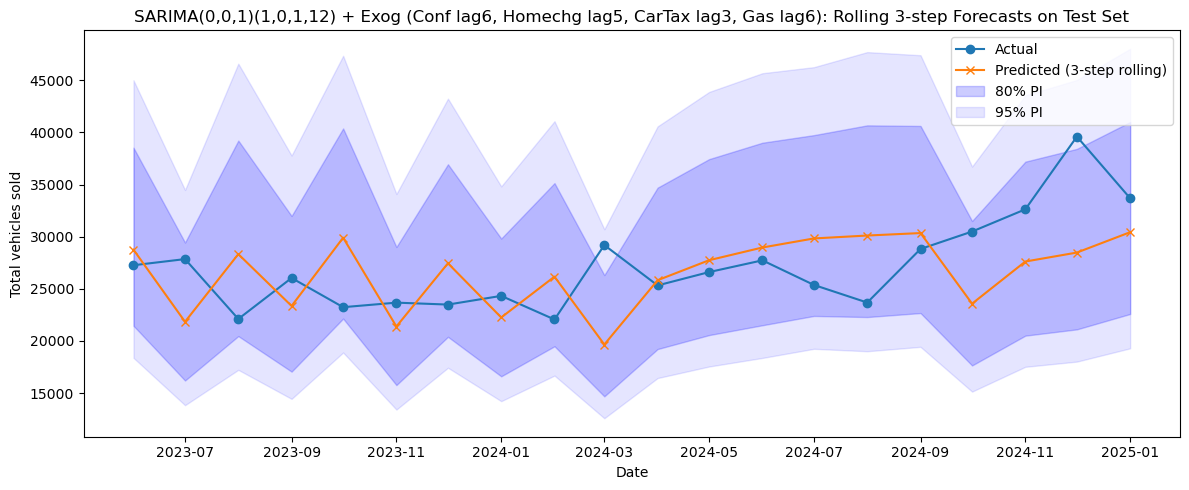

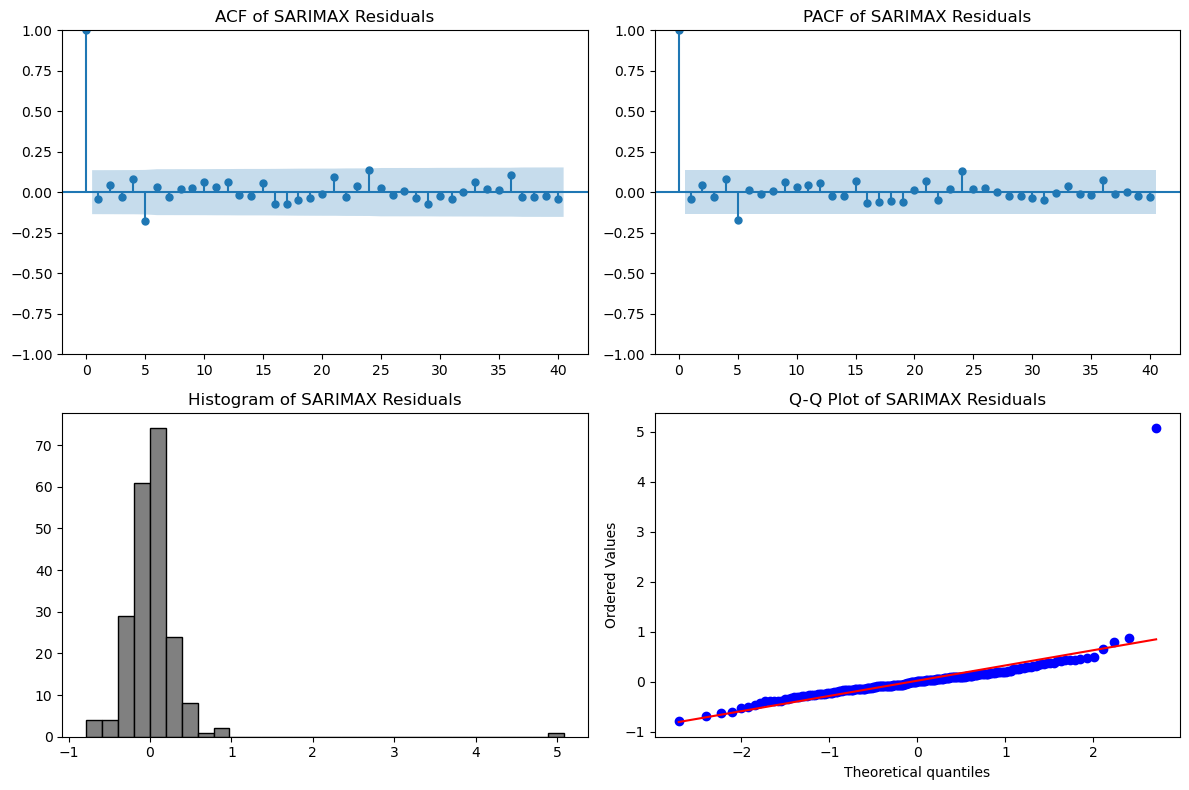

Ljung-Box test p-values (no autocorrelation if > 0.05):
      lb_stat  lb_pvalue
10  11.191649   0.342783
20  16.522554   0.683723
30  25.139298   0.718234


In [ ]:


# ─── 1. Prepare data ───────────────────────────────────────────────────────────
conf_bc    = boxcox_all['Consumer confidence (E)']
homechg_bc = boxcox_all['Home charging (G)']
car_tax_bc = boxcox_all['Company car tax rate (%)']
gas_bc     = boxcox_all['Gasoline (Euro95) - Average price (F)']
target_bc  = boxcox_all[target]

history_y        = list(target_bc[:val_end])
history_conf     = list(conf_bc[:val_end])
history_homechg  = list(homechg_bc[:val_end])
history_tax      = list(car_tax_bc[:val_end])
history_gas      = list(gas_bc[:val_end])

test_y        = target_bc[val_end:]
test_conf     = conf_bc[val_end:]
test_homechg  = homechg_bc[val_end:]
test_tax      = car_tax_bc[val_end:]
test_gas      = gas_bc[val_end:]

horizon = 3
lags    = [6, 5, 3, 6]  # lags for conf, homechg, tax, gas

predictions_bc = []
conf_int_80    = []
conf_int_95    = []

# ─── 2. Rolling loop ────────────────────────────────────────────────────────────
for t in range(len(test_y) - horizon + 1):
    # Lag all exogenous variables
    conf_hist    = np.array(history_conf)
    homechg_hist = np.array(history_homechg)
    tax_hist     = np.array(history_tax)
    gas_hist     = np.array(history_gas)

    conf_hist_lag6    = np.roll(conf_hist, lags[0]); conf_hist_lag6[:lags[0]] = np.nan
    homechg_hist_lag5 = np.roll(homechg_hist, lags[1]); homechg_hist_lag5[:lags[1]] = np.nan
    tax_hist_lag3     = np.roll(tax_hist, lags[2]); tax_hist_lag3[:lags[2]] = np.nan
    gas_hist_lag6     = np.roll(gas_hist, lags[3]); gas_hist_lag6[:lags[3]] = np.nan

    # Align all (drop first 6)
    y_hist = np.array(history_y)[6:]
    exog_hist = np.column_stack([
        conf_hist_lag6[6:], homechg_hist_lag5[6:], tax_hist_lag3[6:], gas_hist_lag6[6:]
    ])

    # Fit SARIMAX on history
    model = SARIMAX(
        y_hist,
        exog=exog_hist,
        order=(1, 0, 2),
        seasonal_order=(0, 0, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted = model.fit(disp=False)

    # Recursive 3-step forecast with intervals
    temp_history_y        = history_y.copy()
    temp_history_conf     = history_conf.copy()
    temp_history_homechg  = history_homechg.copy()
    temp_history_tax      = history_tax.copy()
    temp_history_gas      = history_gas.copy()
    for step in range(horizon):
        idx = t + step
        conf_exog_full    = np.concatenate([np.array(temp_history_conf)[-lags[0]:], [test_conf[idx]]])
        homechg_exog_full = np.concatenate([np.array(temp_history_homechg)[-lags[1]:], [test_homechg[idx]]])
        tax_exog_full     = np.concatenate([np.array(temp_history_tax)[-lags[2]:], [test_tax[idx]]])
        gas_exog_full     = np.concatenate([np.array(temp_history_gas)[-lags[3]:], [test_gas[idx]]])
        conf_exog_lag6    = np.roll(conf_exog_full, lags[0])[lags[0]:]
        homechg_exog_lag5 = np.roll(homechg_exog_full, lags[1])[lags[1]:]
        tax_exog_lag3     = np.roll(tax_exog_full, lags[2])[lags[2]:]
        gas_exog_lag6     = np.roll(gas_exog_full, lags[3])[lags[3]:]
        exog_next = np.column_stack([
            conf_exog_lag6, homechg_exog_lag5, tax_exog_lag3, gas_exog_lag6
        ])
        res = fitted.get_forecast(steps=1, exog=exog_next)
        yhat = res.predicted_mean[0]
        ci_80 = res.conf_int(alpha=0.20)[0]
        ci_95 = res.conf_int(alpha=0.05)[0]
        temp_history_y.append(yhat)
        temp_history_conf.append(test_conf[idx])
        temp_history_homechg.append(test_homechg[idx])
        temp_history_tax.append(test_tax[idx])
        temp_history_gas.append(test_gas[idx])
    predictions_bc.append(yhat)
    conf_int_80.append(ci_80)
    conf_int_95.append(ci_95)

    # Update rolling history with actuals for next window
    history_y.append(test_y[t])
    history_conf.append(test_conf[t])
    history_homechg.append(test_homechg[t])
    history_tax.append(test_tax[t])
    history_gas.append(test_gas[t])

# ─── 3. Invert Box–Cox & compute metrics ────────────────────────────────────────
lam, shift = boxcox_lambdas_all[target]
def inv_boxcox(y, lam):
    return np.exp(y) if lam == 0 else np.power(lam * y + 1, 1/lam)

pred_bc = np.array(predictions_bc)
pred_orig  = inv_boxcox(pred_bc, lam) - shift
actuals    = y_test.values[horizon-1:]

conf_int_80 = np.array(conf_int_80)
conf_int_95 = np.array(conf_int_95)
ci_80_lower = inv_boxcox(conf_int_80[:, 0], lam) - shift
ci_80_upper = inv_boxcox(conf_int_80[:, 1], lam) - shift
ci_95_lower = inv_boxcox(conf_int_95[:, 0], lam) - shift
ci_95_upper = inv_boxcox(conf_int_95[:, 1], lam) - shift

rmse_rolling = np.sqrt(mean_squared_error(actuals, pred_orig))
mape_rolling = mean_absolute_percentage_error(actuals, pred_orig)
print(f"Test RMSE (3-step rolling): {rmse_rolling:.2f}")
print(f"Test MAPE (3-step rolling): {mape_rolling:.2%}")

# ─── 4. Plot results ────────────────────────────────────────────────────────────
x_dates = df["Time Period (T)"][val_end+horizon-1:]
plt.figure(figsize=(12, 5))
plt.plot(x_dates, actuals, label='Actual', marker='o')
plt.plot(x_dates, pred_orig, label='Predicted (3-step rolling)', marker='x')
plt.fill_between(x_dates, ci_80_lower, ci_80_upper, color='blue', alpha=0.2, label='80% PI')
plt.fill_between(x_dates, ci_95_lower, ci_95_upper, color='blue', alpha=0.1, label='95% PI')
plt.title('SARIMA(0,0,1)(1,0,1,12) + Exog (Conf lag6, Homechg lag5, CarTax lag3, Gas lag6): Rolling 3-step Forecasts on Test Set')
plt.xlabel('Date')
plt.ylabel('Total vehicles sold')
plt.legend()
plt.tight_layout()
plt.show()

# ─── 5. Residual diagnostics ────────────────────────────────────────────────────
import scipy.stats as stats

# Get residuals from the last fitted SARIMAX model in the rolling loop
residuals = fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF plot
plot_acf(residuals, ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF of SARIMAX Residuals")

# PACF plot
plot_pacf(residuals, ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF of SARIMAX Residuals")

# Histogram
axes[1, 0].hist(residuals, bins=30, color='gray', edgecolor='black')
axes[1, 0].set_title("Histogram of SARIMAX Residuals")

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of SARIMAX Residuals")

plt.tight_layout()
plt.show()

# Ljung-Box test for autocorrelation (white noise)
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box test p-values (no autocorrelation if > 0.05):")
print(lb_test[['lb_stat', 'lb_pvalue']])

MAPE values are all in a similar range (15–18%), which suggests no feature is dramatically improving or worsening the forecast.
RMSE for "All on test" is higher than for "All" on validation, which is expected due to test set uncertainty, but the drop in MAPE (to 15.84%) is a bit unusual—typically, RMSE and MAPE move together. This could be due to outliers or a shift in the test set distribution.
Adding exogenous features does not drastically improve RMSE/MAPE compared to baseline, which may indicate:
The target is mostly explained by its own lags.
Exogenous features are not strongly predictive, or lag choices could be further optimized.
No negative RMSE/MAPE or extreme values, so the model is numerically stable.